# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
# data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# data visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 30, 15
sns.set(context='talk', style='darkgrid', palette='muted', font='sans-serif', font_scale=1, color_codes=False,
        rc=None)

# Algorithms
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

## Изучение данных
### Данные об электродах

In [2]:
data_electrodes = pd.read_csv('./datasets/final_steel/data_arc.csv')
display(data_electrodes)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [3]:
data_electrodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_electrodes.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


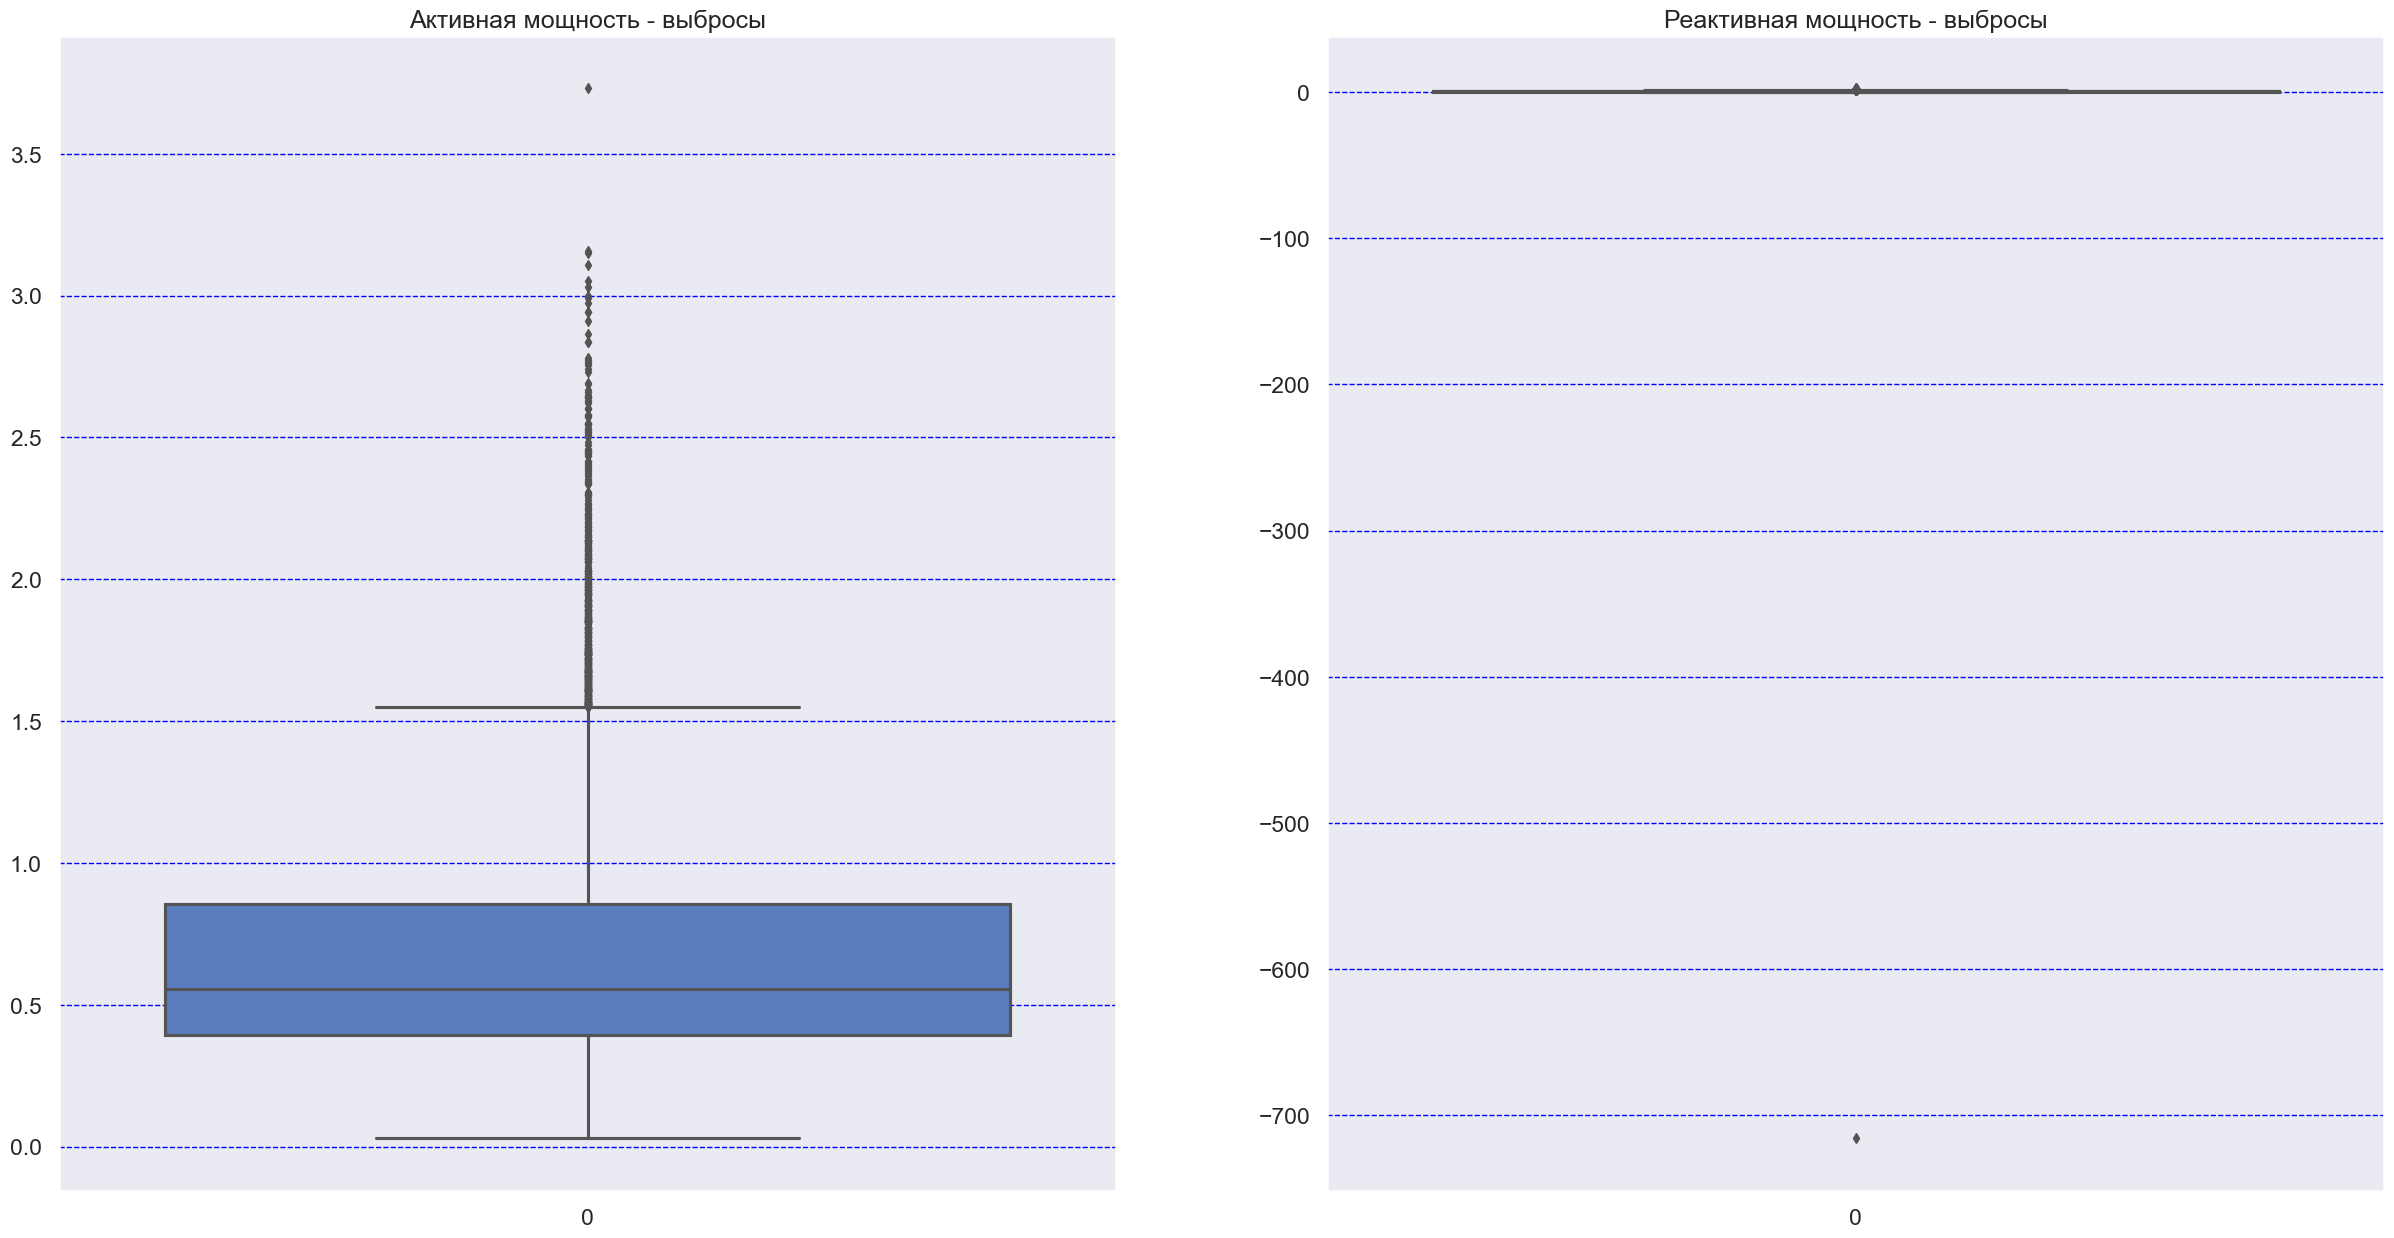

In [5]:
plt.subplot(121)
plt.title('Активная мощность - выбросы')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_electrodes['Активная мощность'])

plt.subplot(122)
plt.title('Реактивная мощность - выбросы')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_electrodes['Реактивная мощность'])

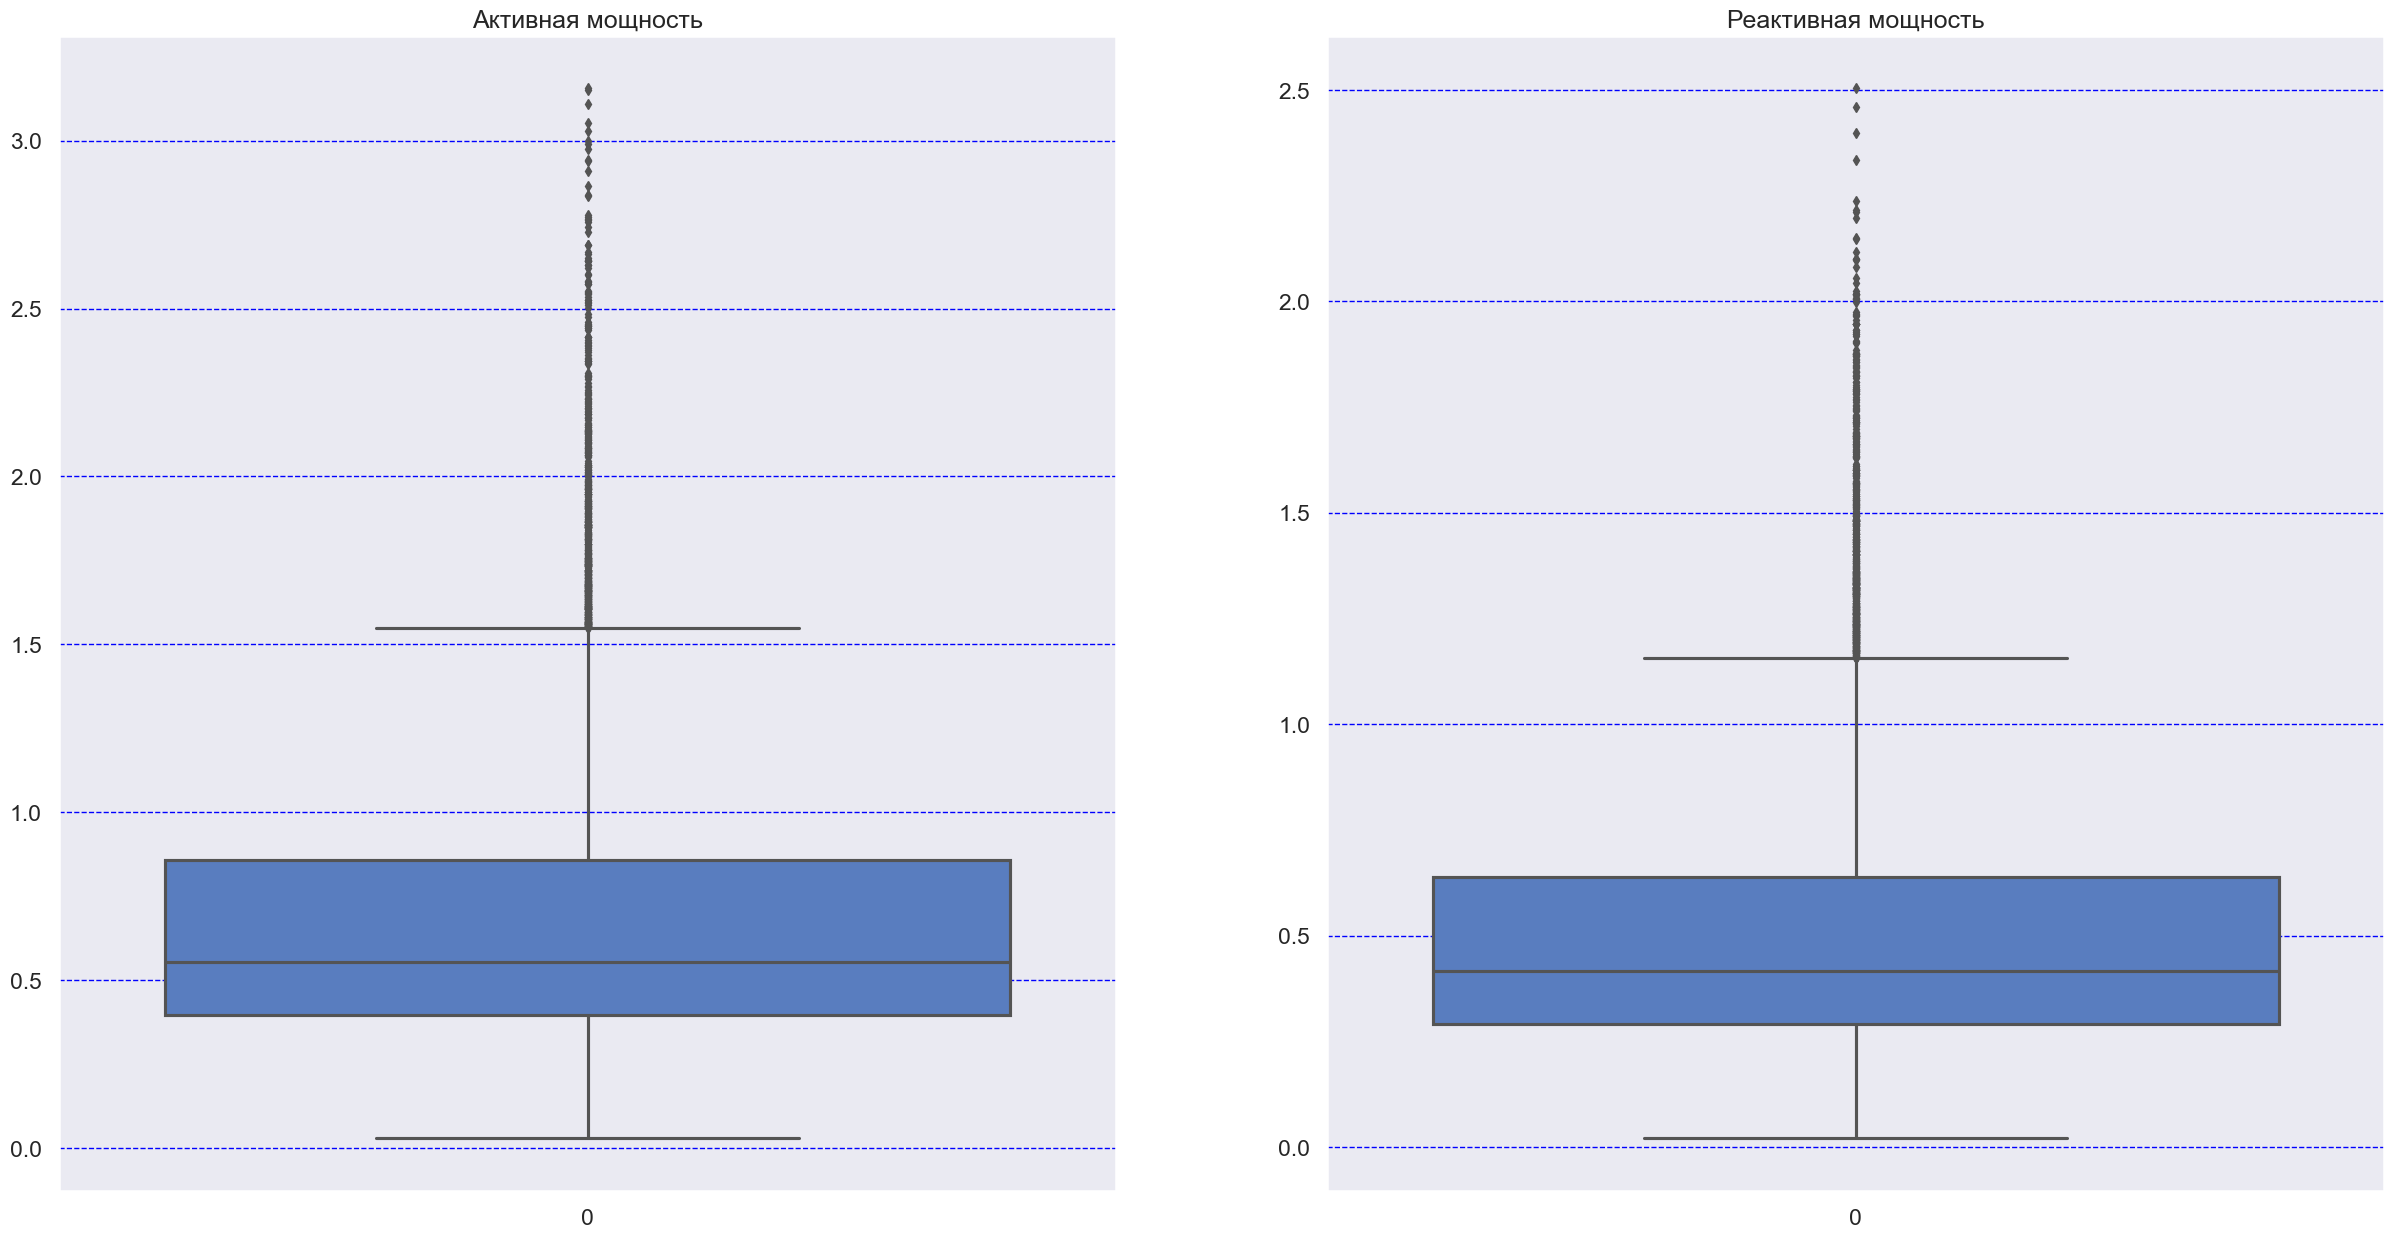

In [6]:
# удалим явные выбросы
data_electrodes = data_electrodes.loc[data_electrodes['Активная мощность'] < 3.5]
data_electrodes = data_electrodes.loc[data_electrodes['Реактивная мощность'] > -100]

plt.subplot(121)
plt.title('Активная мощность')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_electrodes['Активная мощность'])

plt.subplot(122)
plt.title('Реактивная мощность')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_electrodes['Реактивная мощность'])

#### Длительность времени между первым и последним замером температуры.

In [7]:
# преобразуем типы данных
data_electrodes['Начало нагрева дугой'] = pd.to_datetime(data_electrodes['Начало нагрева дугой'])
data_electrodes['Конец нагрева дугой'] = pd.to_datetime(data_electrodes['Конец нагрева дугой'])
data_electrodes.dtypes

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object

In [8]:
# рассчитаем продолжительность нагрева в секундах
data_electrodes['heat_duration'] = data_electrodes['Конец нагрева дугой'] - data_electrodes['Начало нагрева дугой']
data_electrodes['heat_duration'] = data_electrodes['heat_duration'] / pd.Timedelta(seconds=1)
data_electrodes = data_electrodes.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
display(data_electrodes.head(20))

,key,Активная мощность,Реактивная мощность,heat_duration
0,1,0.976059,0.687084,228.0
1,1,0.805607,0.520285,185.0
2,1,0.744363,0.498805,172.0
3,1,1.659363,1.062669,365.0
4,1,0.692755,0.414397,148.0
5,2,0.438063,0.283043,137.0
6,2,1.296415,0.892914,338.0
7,2,0.490377,0.305281,126.0
8,2,0.827743,0.516874,210.0
9,3,1.062053,0.671494,280.0


#### Суммарное время нагрева электродами (сумма значений по всем промежуткам между запусками нагрева электродов).

In [9]:
data_electrodes = data_electrodes.groupby('key').sum().reset_index().rename\
(columns={'Активная мощность':'activ_pow_batch', 'Реактивная мощность':'reactiv_pow_batch', 'heat_duration':'heating_batch'})
display(data_electrodes)

,key,activ_pow_batch,reactiv_pow_batch,heating_batch
0,1,4.878147,3.183241,1098.0
1,2,3.052598,1.998112,811.0
2,3,2.525882,1.599076,655.0
3,4,3.209250,2.060298,741.0
4,5,3.347173,2.252643,869.0
...,...,...,...,...
3209,3237,3.932467,2.828459,909.0
3210,3238,2.106529,1.681182,546.0
3211,3239,4.666754,3.111617,1216.0
3212,3240,2.984083,2.483267,839.0


#### Среднее соотношение потребления активной и реактивной мощности.

In [10]:
data_electrodes['ratio_pow'] = data_electrodes['activ_pow_batch'] / data_electrodes['reactiv_pow_batch']
display(data_electrodes)

,key,activ_pow_batch,reactiv_pow_batch,heating_batch,ratio_pow
0,1,4.878147,3.183241,1098.0,1.532447
1,2,3.052598,1.998112,811.0,1.527741
2,3,2.525882,1.599076,655.0,1.579589
3,4,3.209250,2.060298,741.0,1.557663
4,5,3.347173,2.252643,869.0,1.485887
...,...,...,...,...,...
3209,3237,3.932467,2.828459,909.0,1.390321
3210,3238,2.106529,1.681182,546.0,1.253004
3211,3239,4.666754,3.111617,1216.0,1.499784
3212,3240,2.984083,2.483267,839.0,1.201676


<AxesSubplot:>

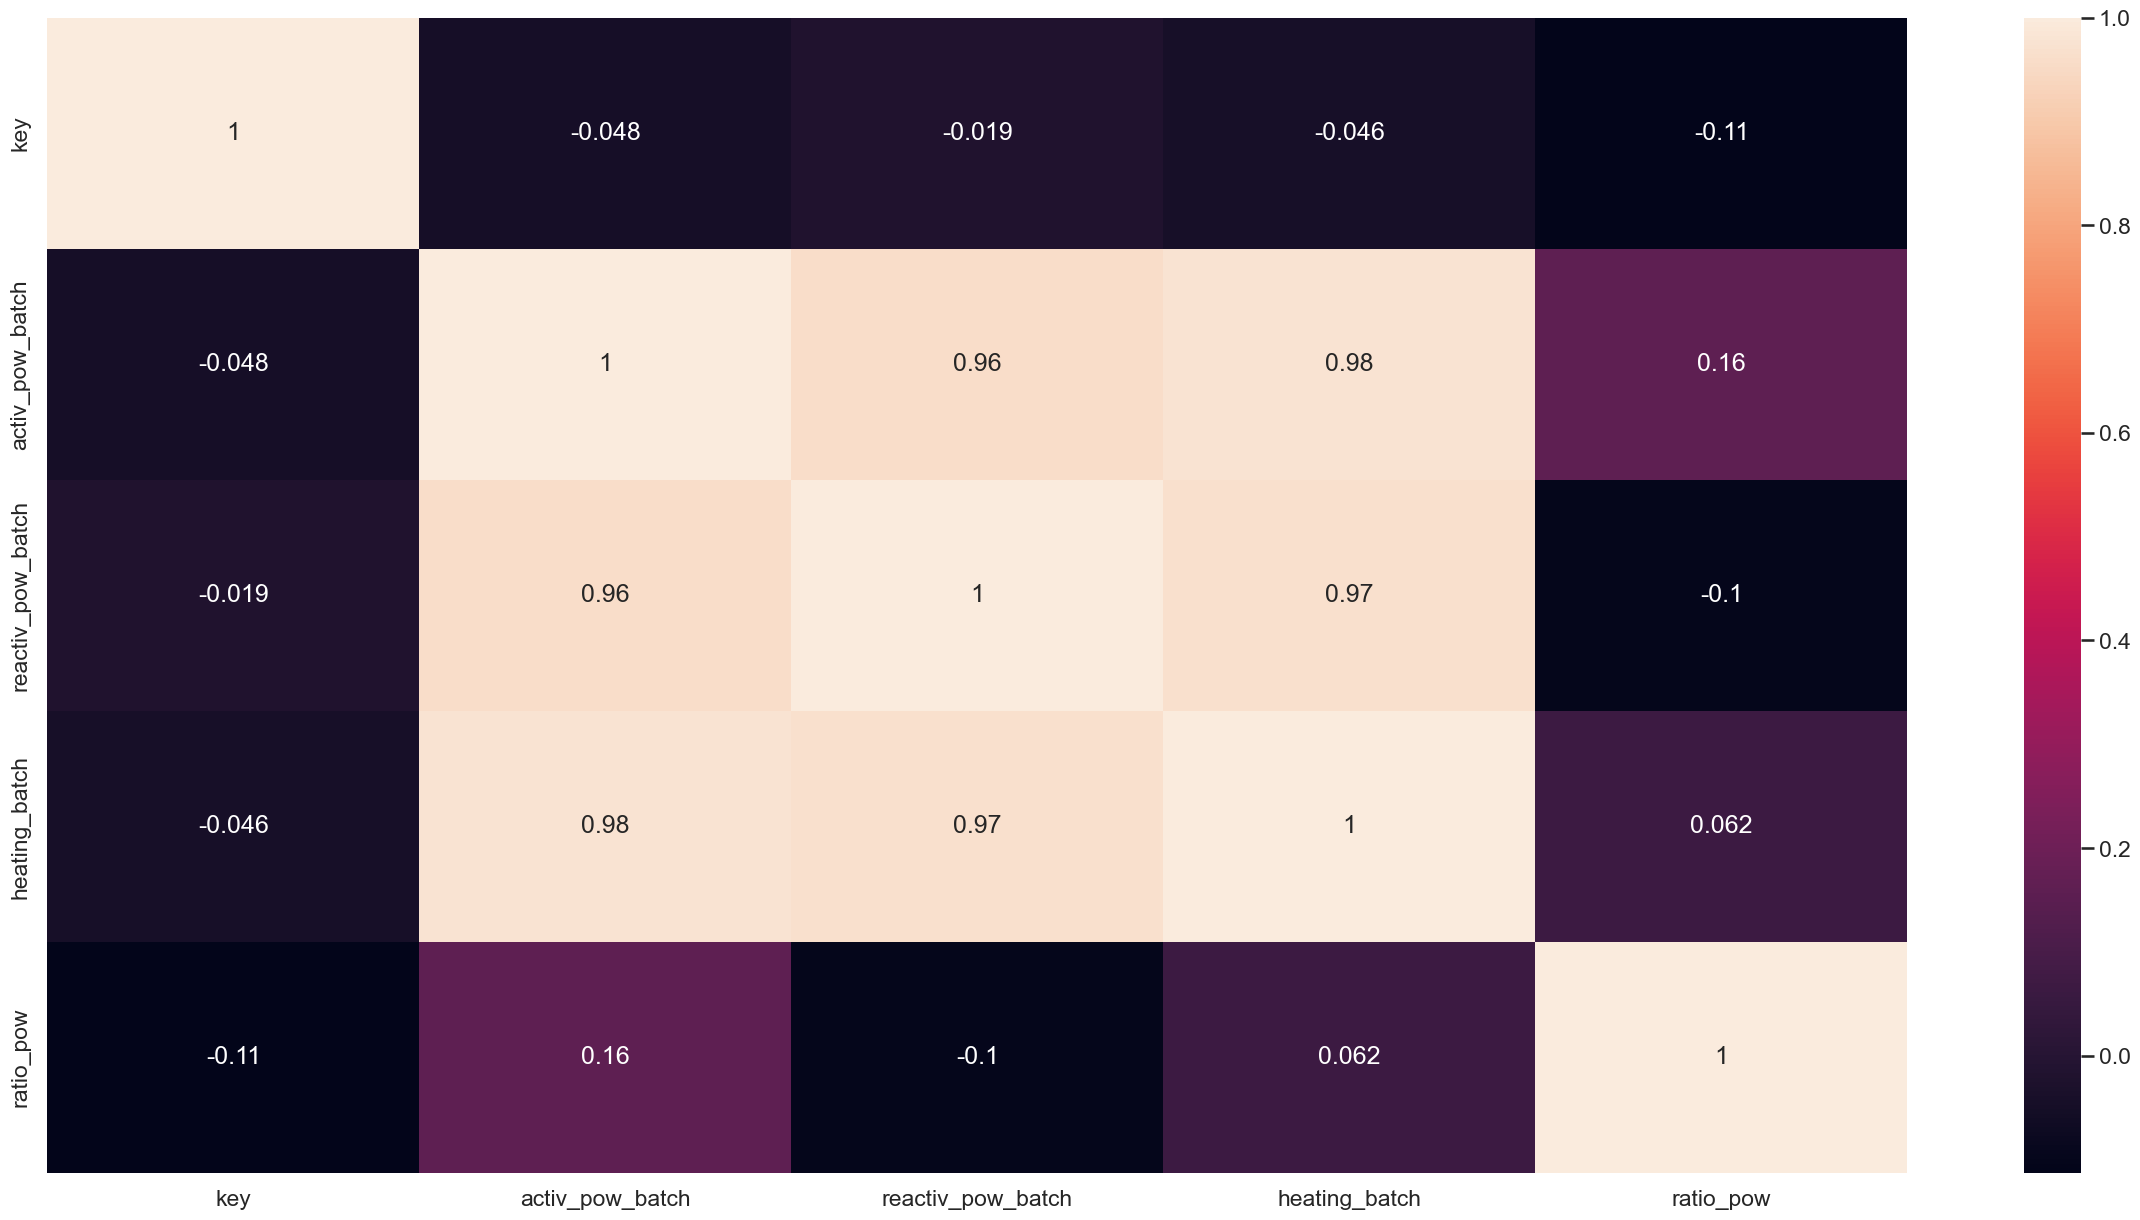

In [11]:
# проверим мультиколлениарность признаков
sns.heatmap(data_electrodes.corr(), annot=True)

### Вывод по данным
В ходе изучения данных об электродах мы выполнили следующие действия:
   - выполнили анализ выбросов в значениях признаков: `Активная мощность`, `Реактивная мощность`
   - обработали выбросы
   - создали дополнительные признаки:
       - `Продолжительность нагрева загрузки (heat_duration)`
       - `Продолжительность нагрева партии (heating_batch)`
       - `Соотношение потребляемой мощности (ratio_pow)`
   - выполнили проверку мультиколленианости признаков, в результате проверки принято решение уменьшить пространство
   признаков за счет удаления `Активная мощность (activ_pow_batch)`, `Реактивная мощность (reactiv_pow_batch)`

### Данные о подаче сыпучих материалов (объем)

In [12]:
data_bulk_volume = pd.read_csv('./datasets/final_steel/data_bulk.csv')
display(data_bulk_volume)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [13]:
data_bulk_volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
# выполним замену пропущенных значений на ноль
data_bulk_volume = data_bulk_volume.fillna(0)

<AxesSubplot:title={'center':'Распределение объемов сыпучих присадок'}>

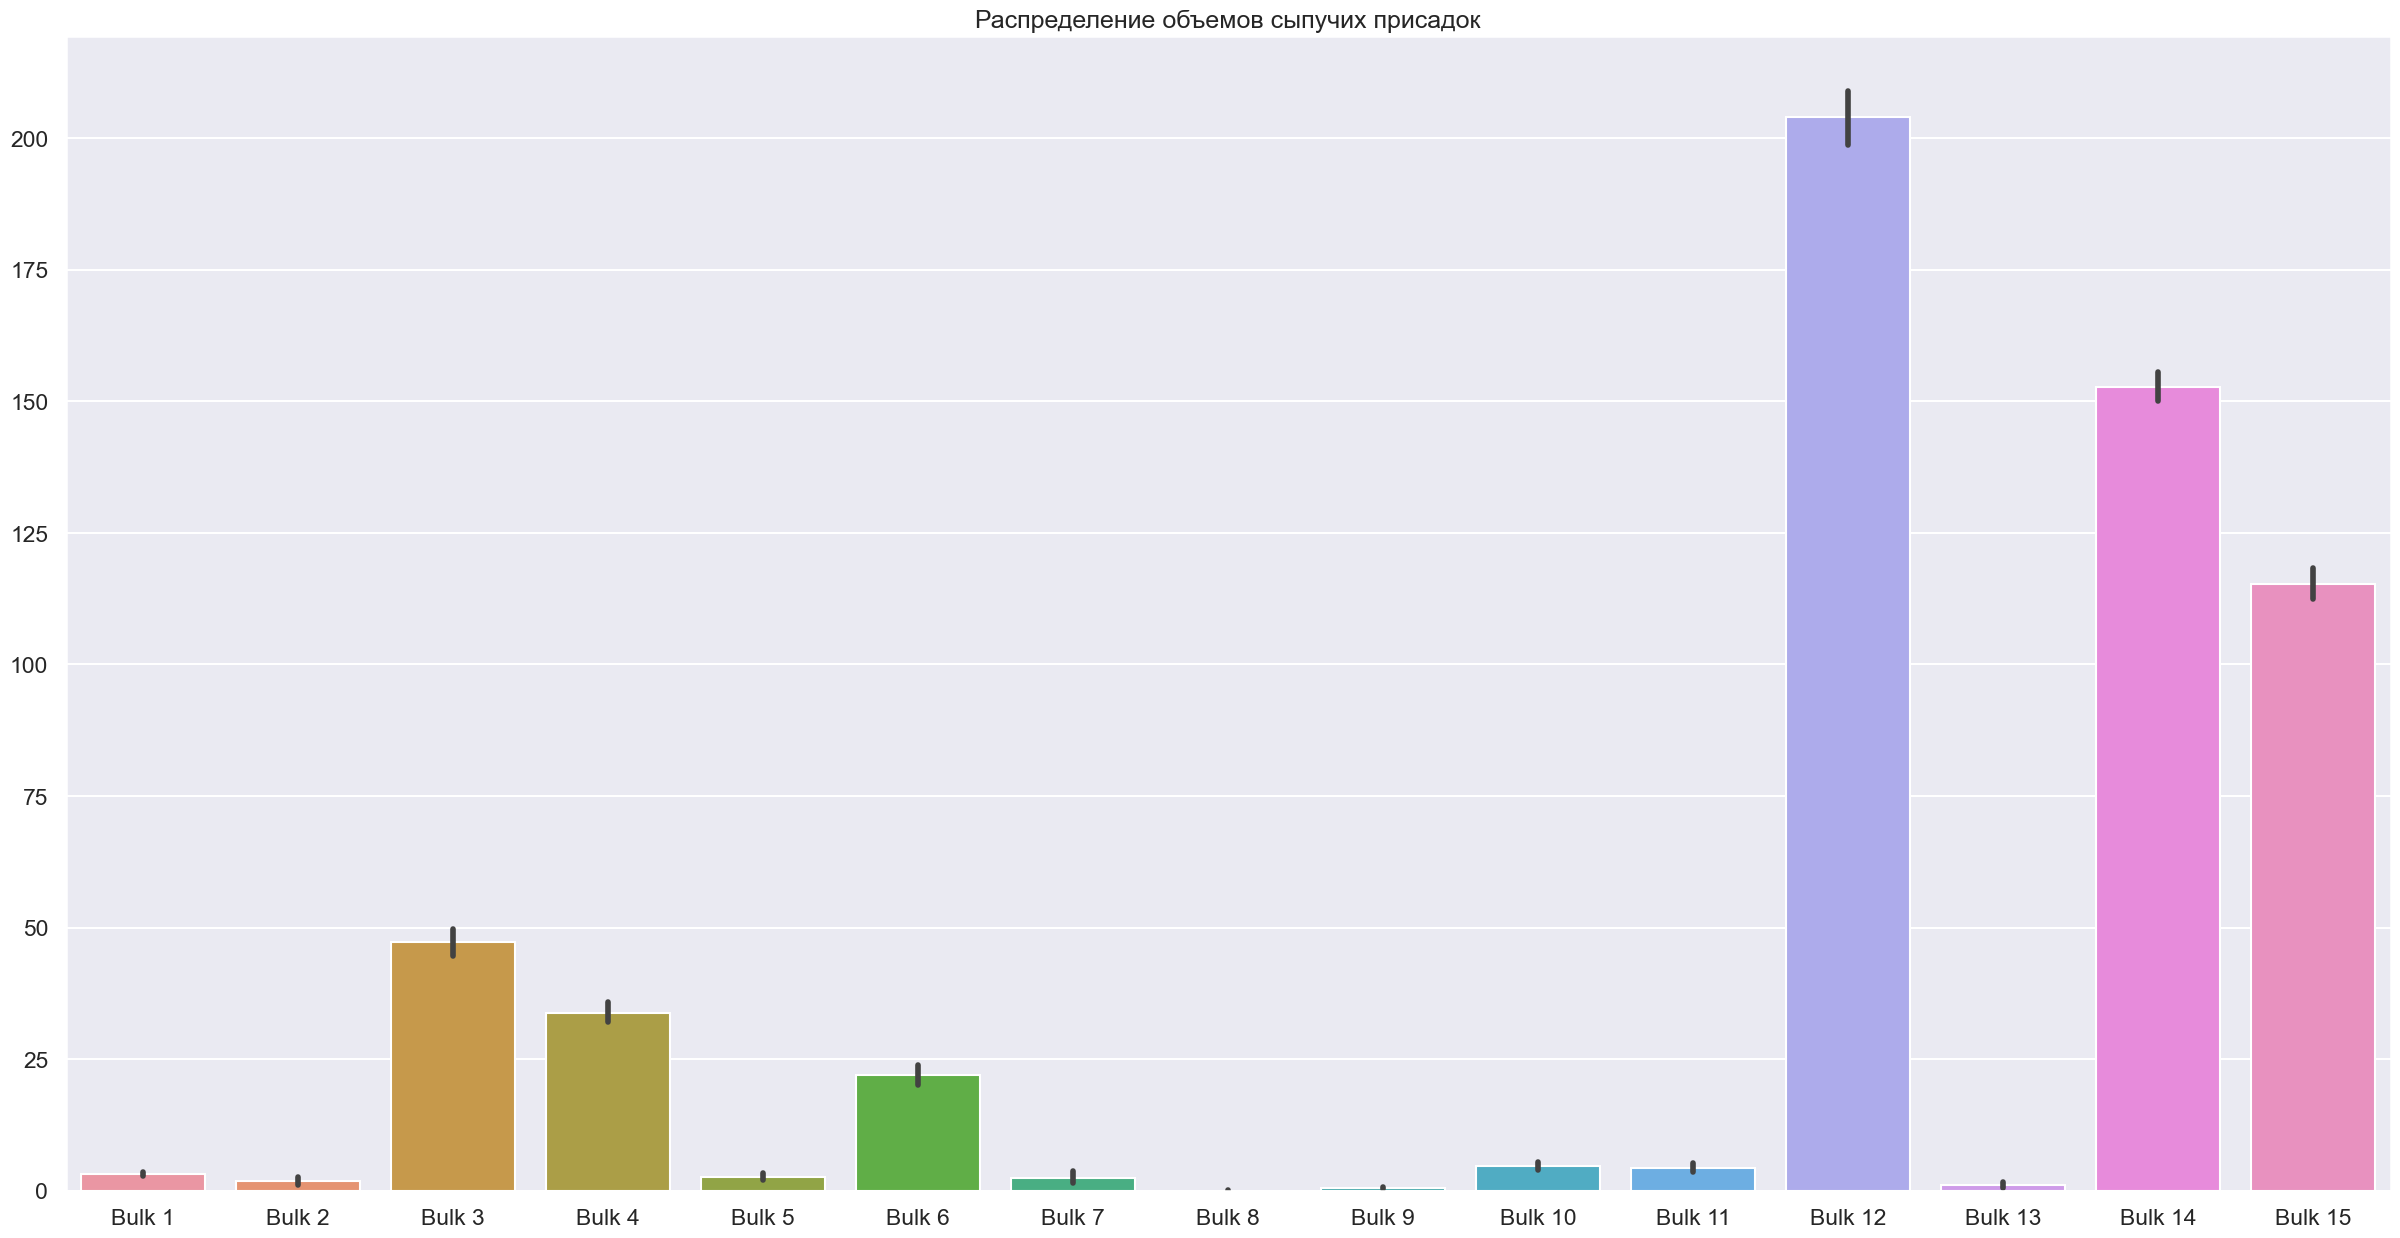

In [15]:
plt.title('Распределение объемов сыпучих присадок')
graf_bulk_valume = data_bulk_volume.drop('key', axis=1)
sns.barplot(graf_bulk_valume)

### Вывод по данным
В ходе изучения данных о подаче сыпучих материалов (объемы) мы выполнили следующие действия:
- принято решение заменить пропуски нулевыми значениями, что означает отсутствие добавки;
- удаляем признак `Bulk 8`

### Данные о подаче сыпучих материалов (время)

In [16]:
data_bulk_time = pd.read_csv('./datasets/final_steel/data_bulk_time.csv')
display(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


### Вывод по данным
Данные о времени подачи сыпучих материалов для решения задачи регрессии игнорируем

### Данные о продувке сплава газом

In [17]:
data_gas = pd.read_csv('./datasets/final_steel/data_gas.csv')
display(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


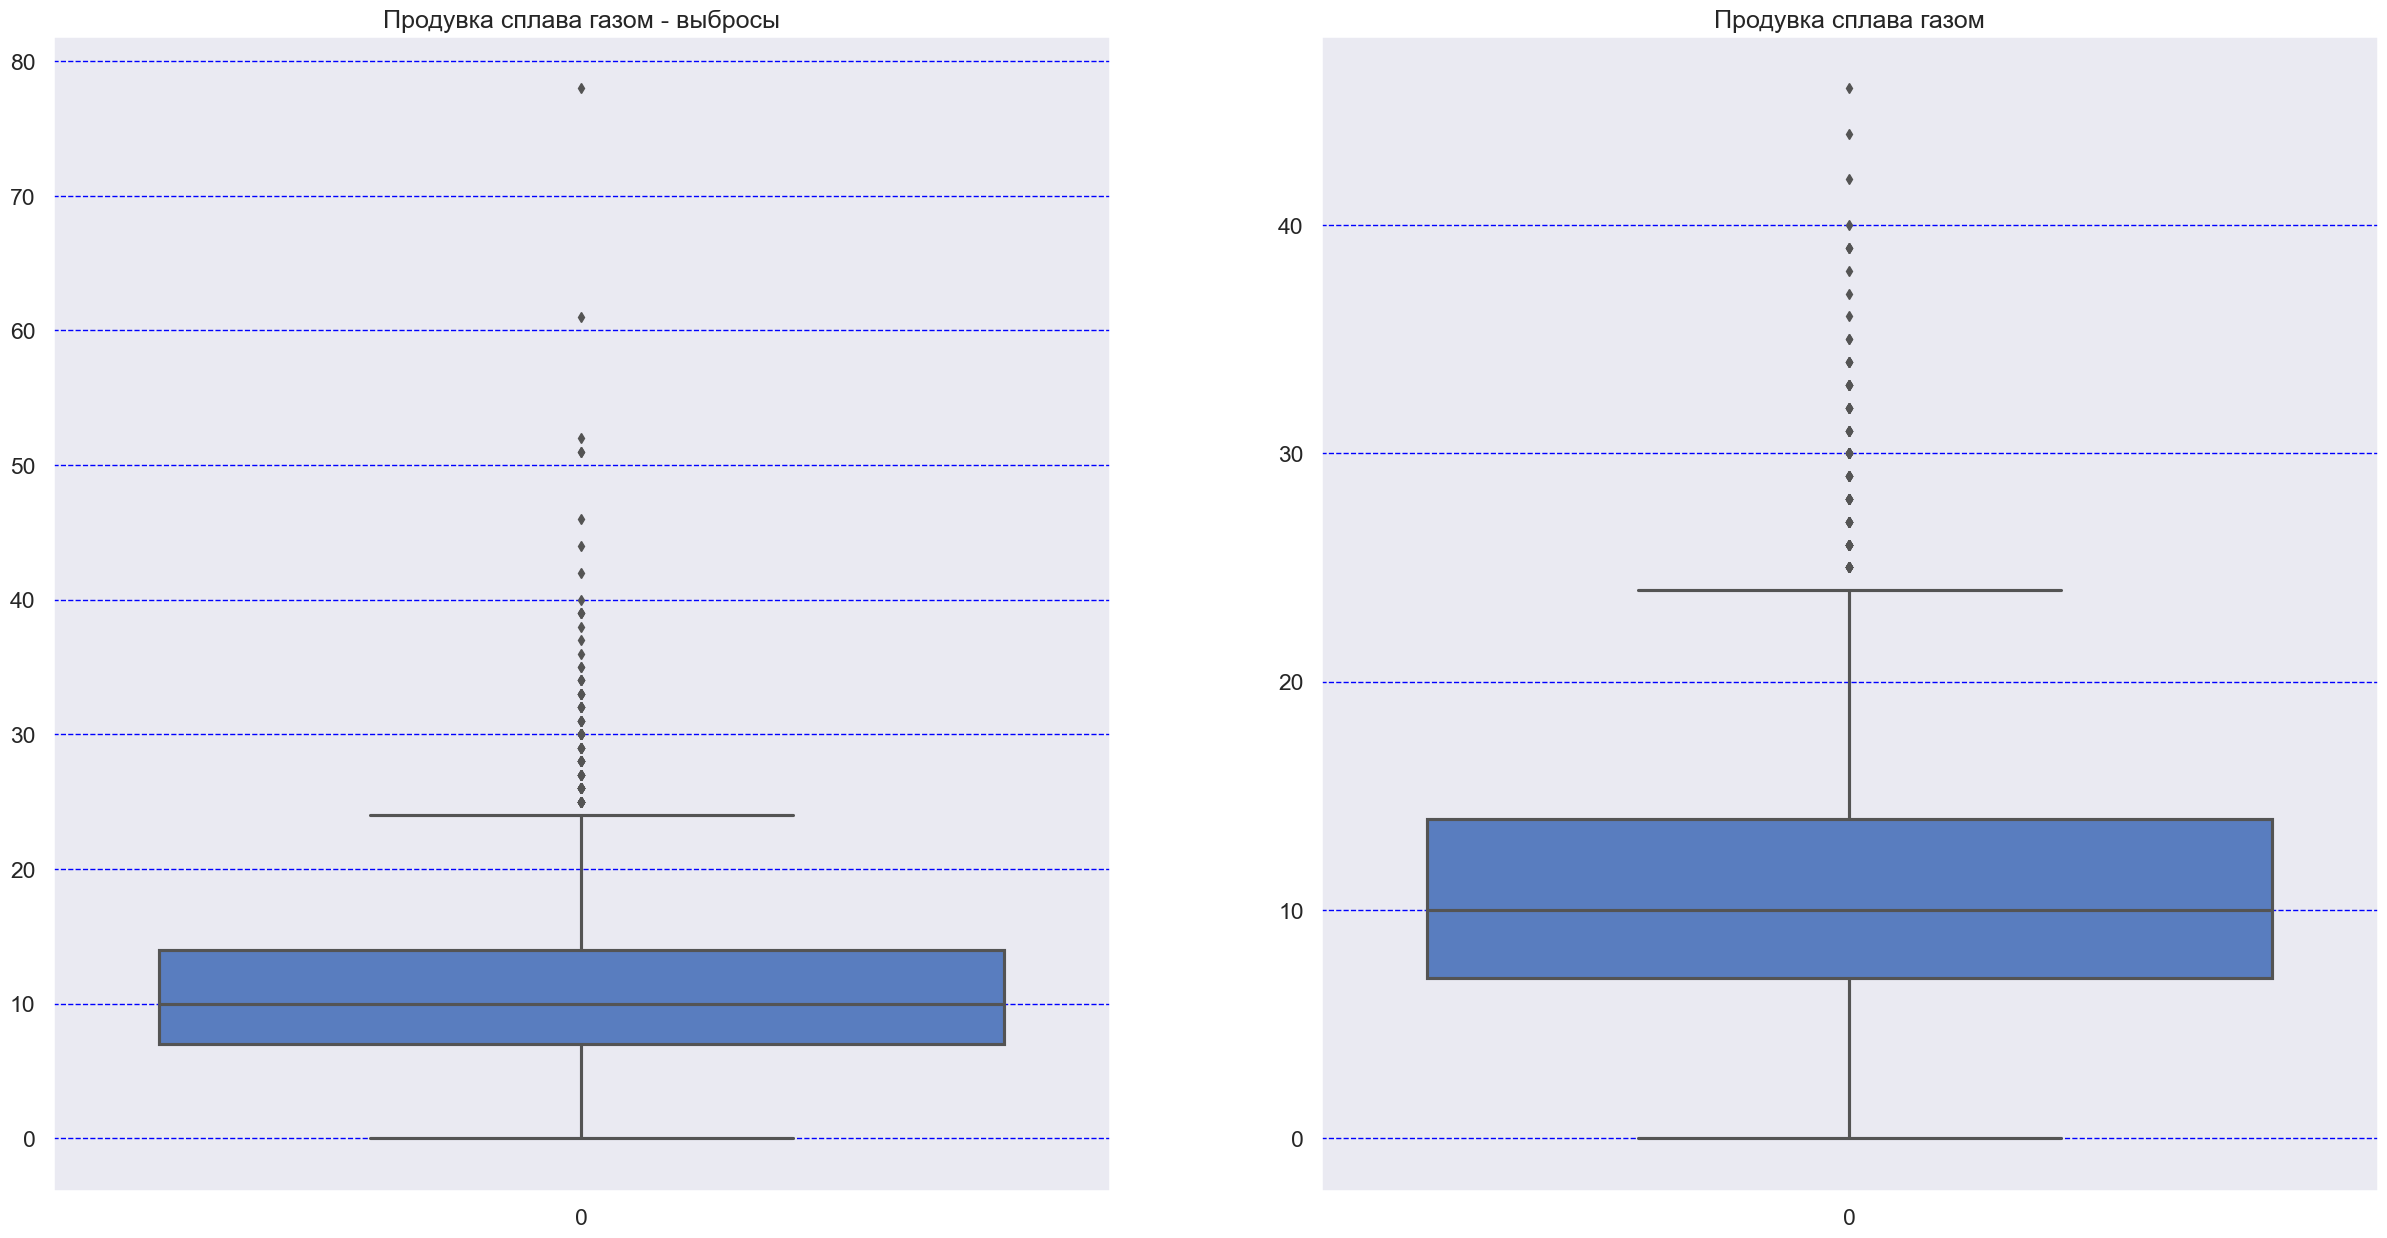

In [18]:
# выполним переименование столбцов
data_gas = round(data_gas.rename(columns={'Газ 1':'gas'}))

plt.subplot(121)
plt.title('Продувка сплава газом - выбросы')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_gas['gas'])
# удалим выбросы
data_gas = data_gas.loc[data_gas['gas'] < 50]

plt.subplot(122)
plt.title('Продувка сплава газом')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_gas['gas'])

### Вывод по данным
В ходе изучения данных о продувке сплава газом мы выполнили следующие действия:
   - выполнили переименование Газ 1 -> `gas`
   - выполнили округление до целого
   - выполнили анализ выбросов
   - обработали выбросы

### Результаты измерения температуры

In [19]:
data_temp = pd.read_csv('./datasets/final_steel/data_temp.csv')
display(data_temp.head(20))

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [20]:
# удалим ненужный столбец
data_temp = data_temp.drop('Время замера', axis=1)
# округлим и переименуем признаки
data_temp = data_temp.rename(columns={'Температура':'temperatur'})

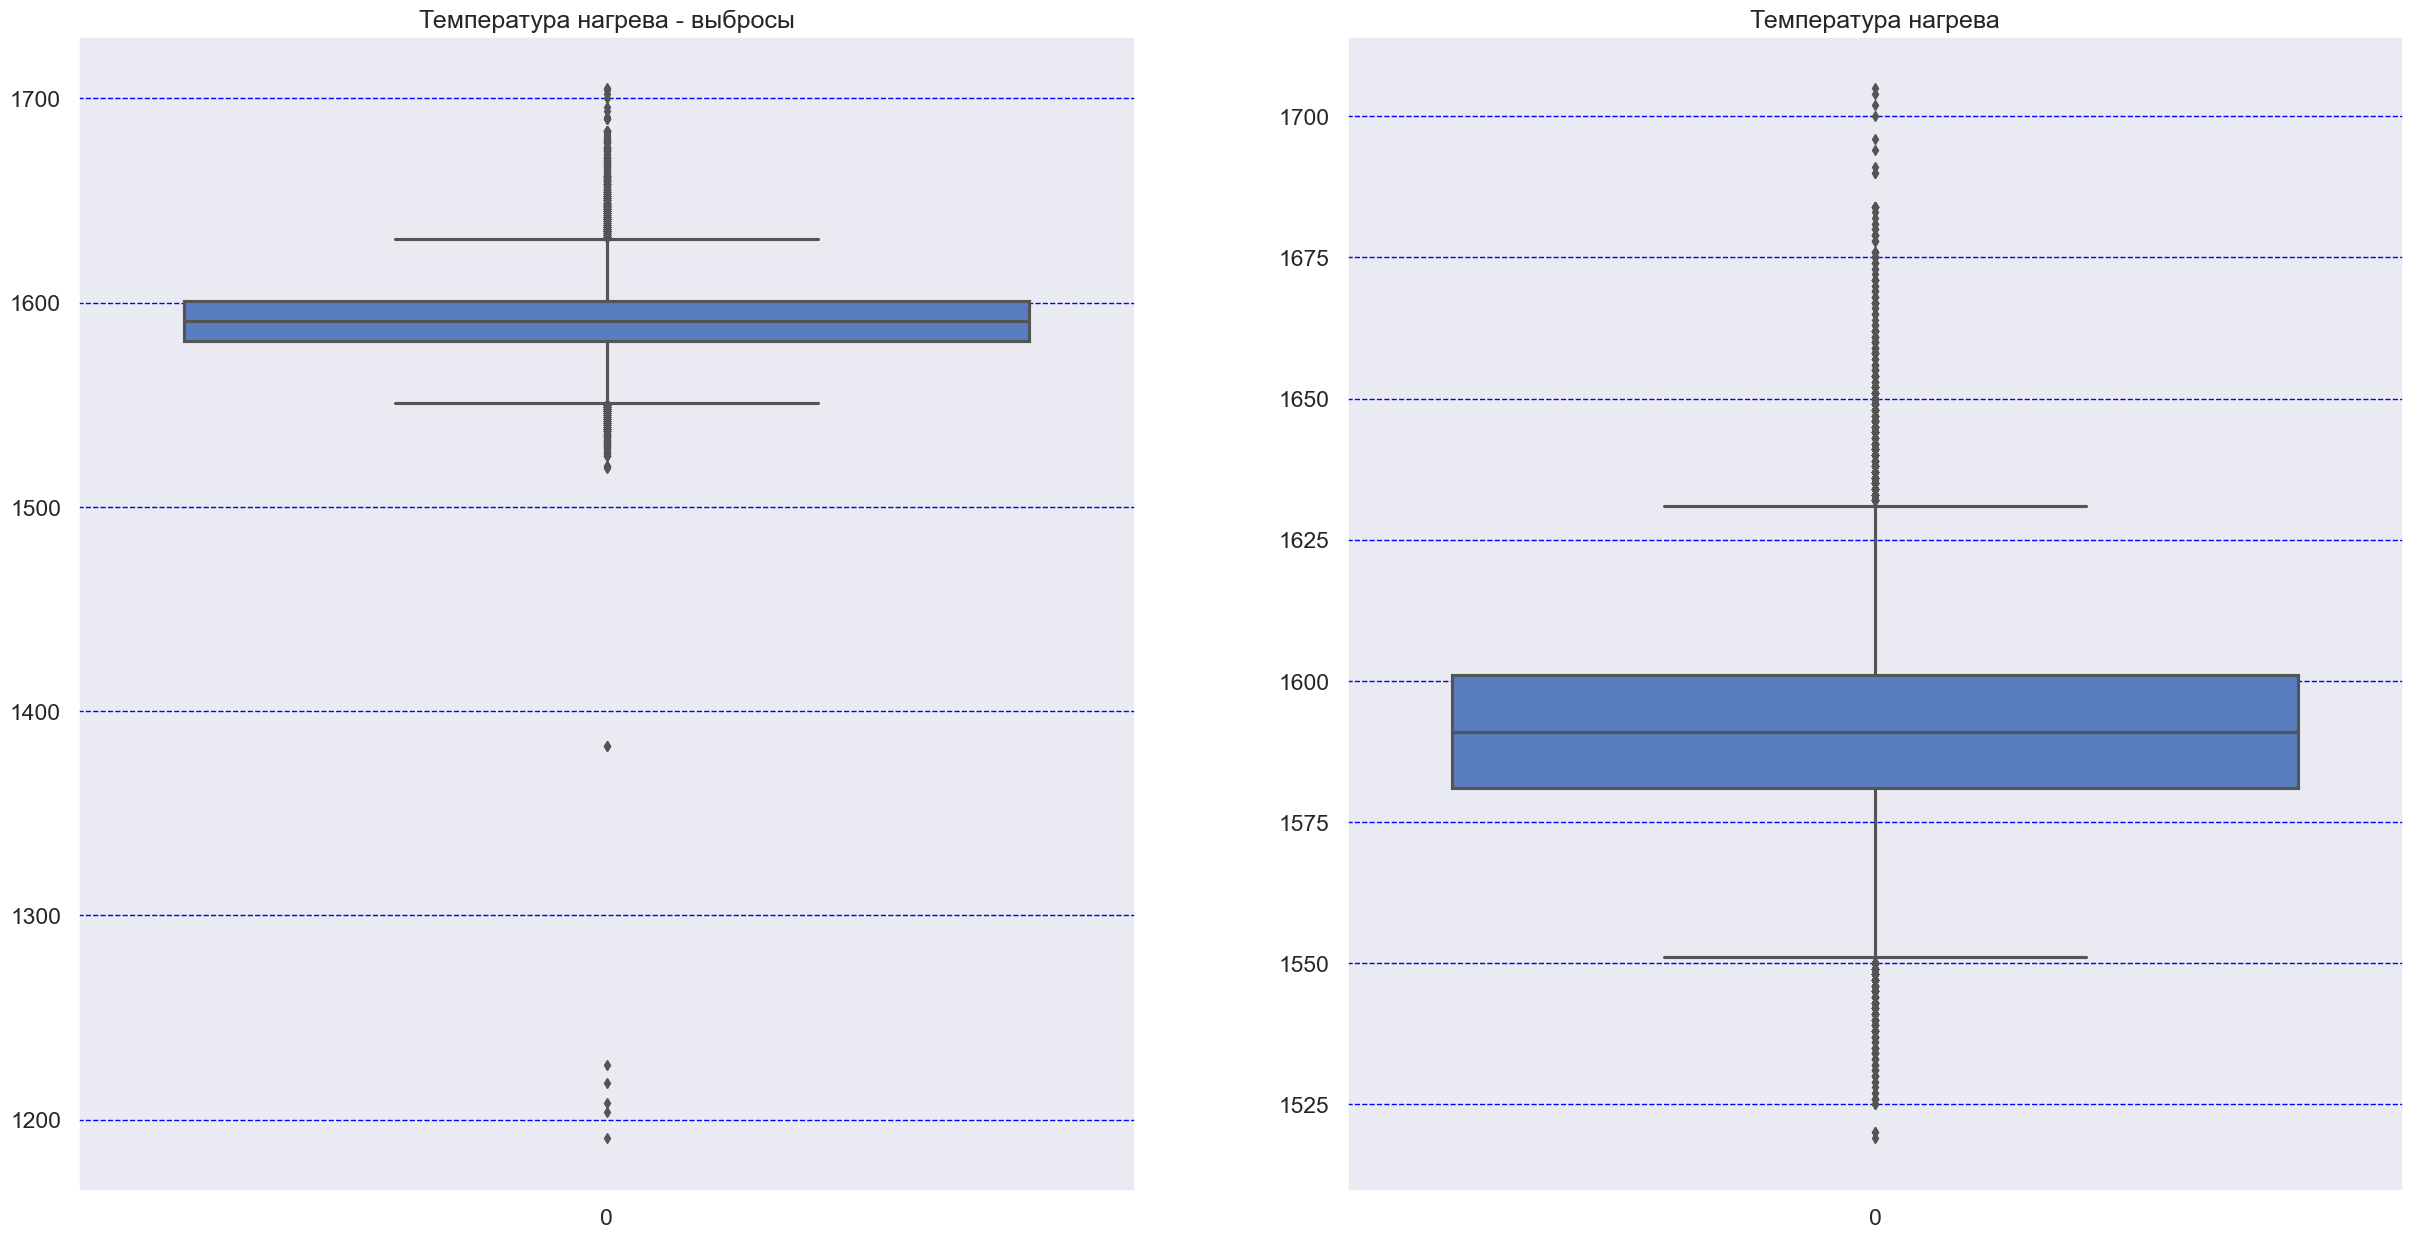

In [21]:
plt.subplot(121)
plt.title('Температура нагрева - выбросы')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_temp['temperatur'])
# удалим выбросы
data_temp = data_temp.loc[data_temp['temperatur'] > 1400]

plt.subplot(122)
plt.title('Температура нагрева')
plt.grid(color='b', linestyle='--', linewidth=1)
ax = sns.boxplot(data_temp['temperatur'])

#### Начальная температура нагрева

In [22]:
initial_heating_temperatur = data_temp.groupby('key').first().reset_index()
display(initial_heating_temperatur)

,key,temperatur
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0
...,...,...
3210,3237,1569.0
3211,3238,1584.0
3212,3239,1598.0
3213,3240,1617.0


#### Выделим метки

In [23]:
#dict_label = data_temp.set_index('key').T.to_dict('list')
dict_label = data_temp.set_index('key').to_dict()['temperatur']
data_label = pd.DataFrame(dict_label.items(), columns=['key', 'label'])
display(data_label)

,key,label
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0
...,...,...
3210,3237,1569.0
3211,3238,1584.0
3212,3239,1598.0
3213,3240,1617.0


In [24]:
# объединим признаки
data_temp = data_label.merge(initial_heating_temperatur, how='inner', on='key')
# исключим равные значения
data_temp = data_temp.loc[data_temp['temperatur'] != data_temp['label']]
display(data_temp)

,key,label,temperatur
0,1,1613.0,1571.0
1,2,1602.0,1581.0
2,3,1599.0,1596.0
3,4,1625.0,1601.0
4,5,1602.0,1576.0
...,...,...,...
2472,2495,1591.0,1570.0
2473,2496,1591.0,1554.0
2474,2497,1589.0,1571.0
2475,2498,1594.0,1591.0


### Вывод по данным
В ходе изучения данных измерения температуры мы выполнили следующие действаия:
   - удалили лишний признак;
   - выполнили переименование признака;
   - выполнили анализ выбросов;
   - температура плавления стали 1400 градусов, поэтому значения температуры менее 1400 градусов удаляем;
   - выделили метки (конечная температура) из каждой партии;
   - создали дополнительный признак `Начальная температура нагрева (temperatur)`

### Данные о проволочных материалах (объем)

In [25]:
data_wire_volume = pd.read_csv('./datasets/final_steel/data_wire.csv')
display(data_wire_volume)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data_wire_volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [27]:
# выполним замену пропущенных значений на ноль
data_wire_volume = data_wire_volume.fillna(0)

<AxesSubplot:title={'center':'Распределение объемов проволочных присадок'}>

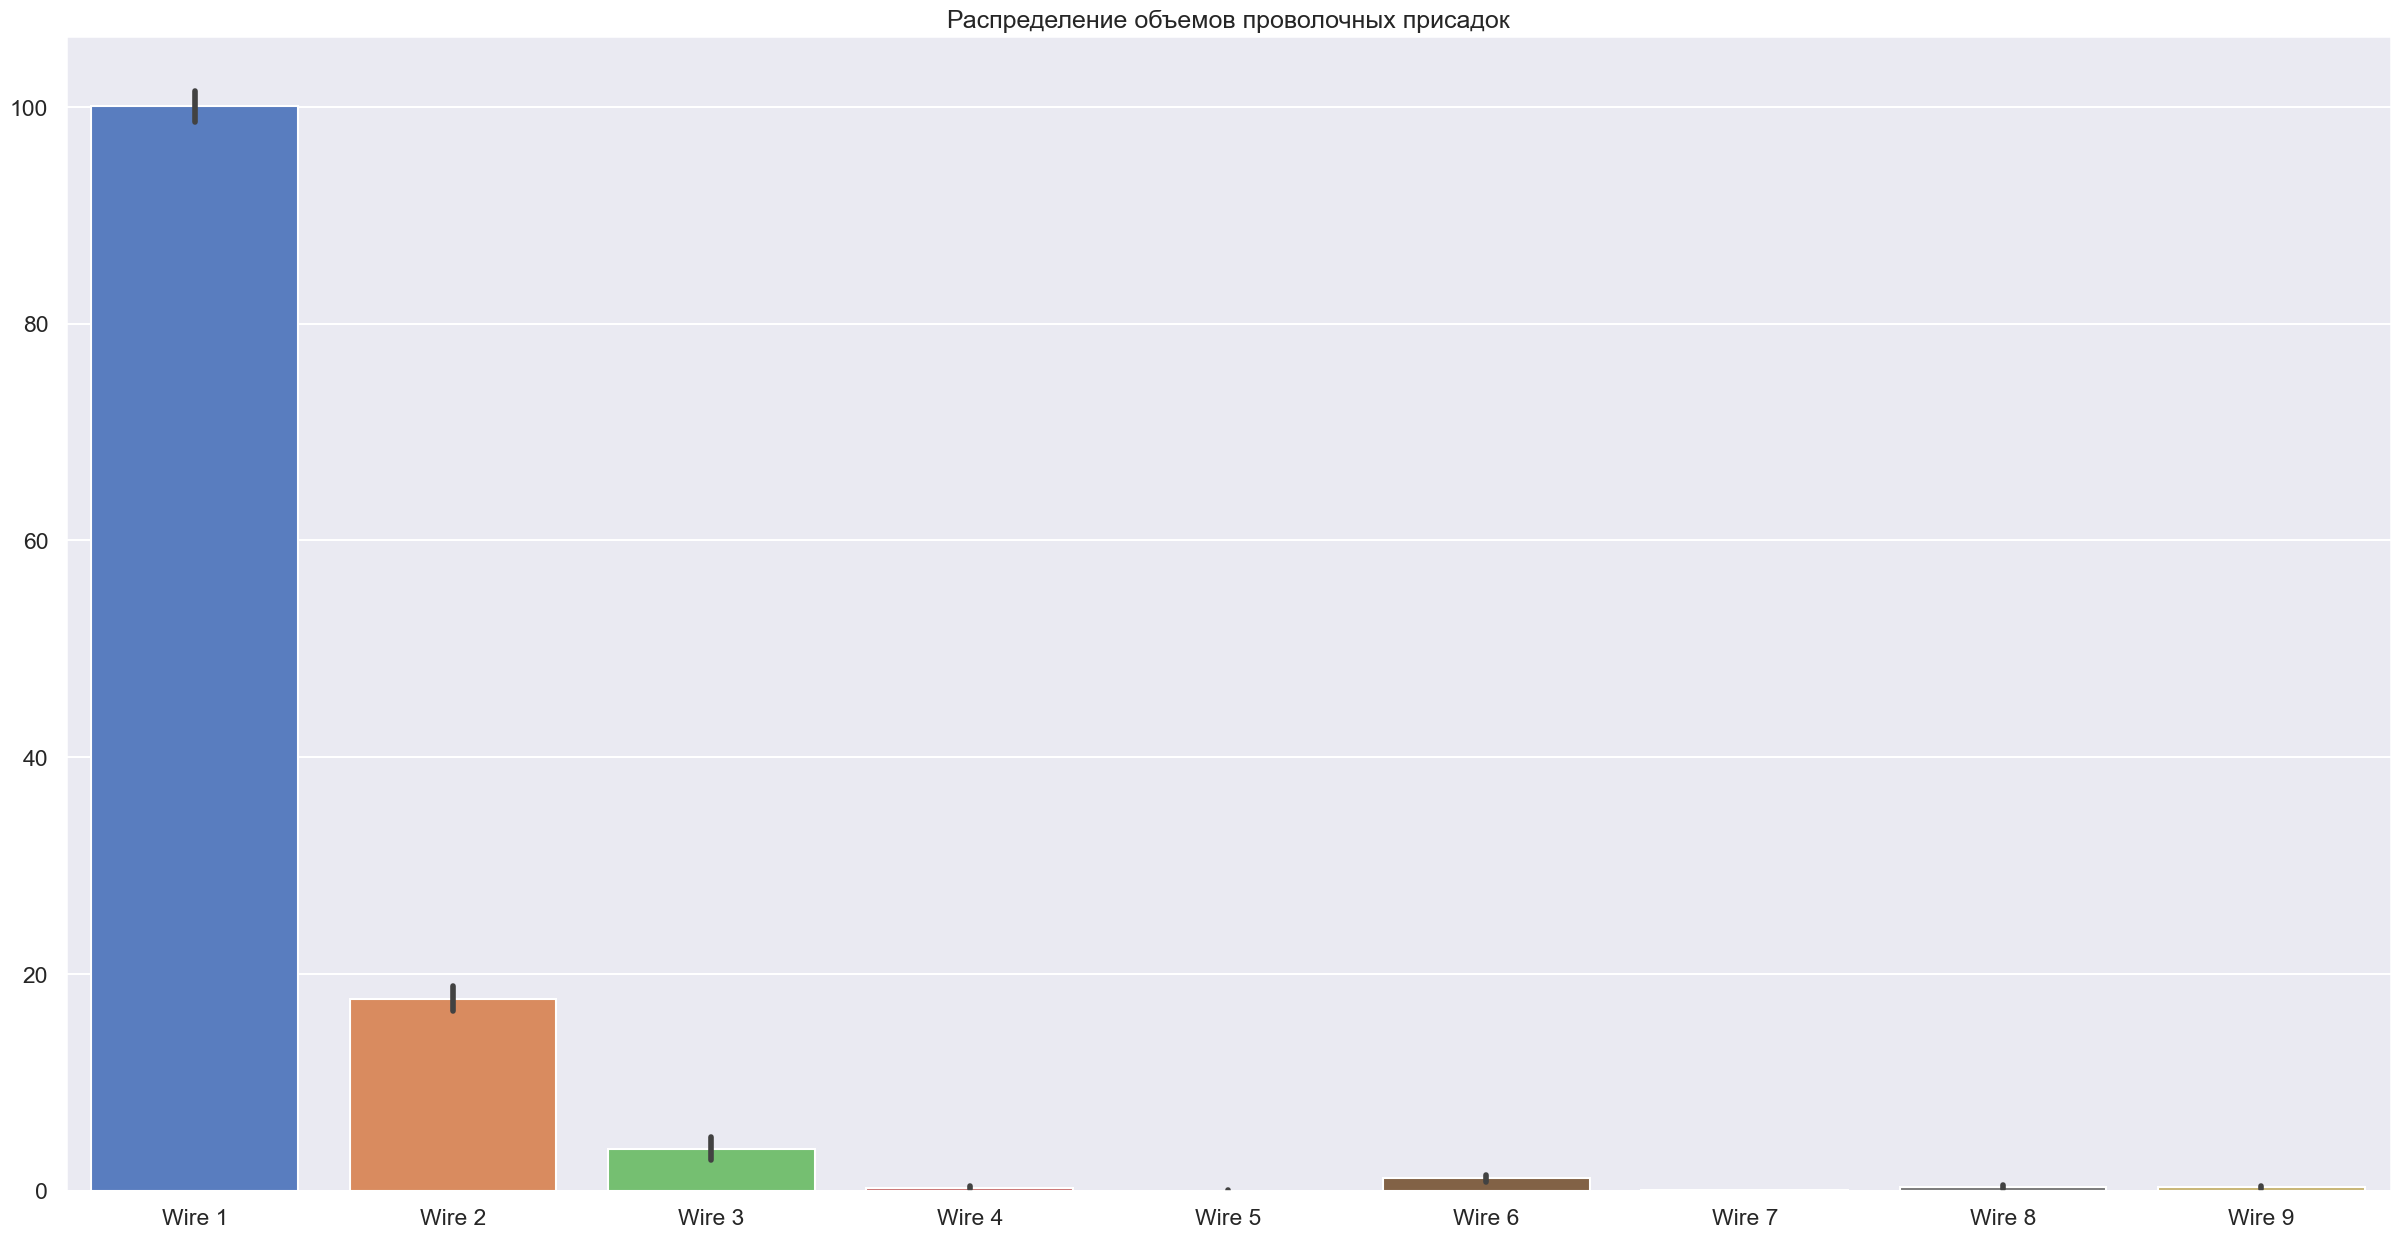

In [28]:
plt.title('Распределение объемов проволочных присадок')
graf_wire_volume = data_wire_volume.drop('key', axis=1)
sns.barplot(graf_wire_volume)

### Вывод по данным
В ходе изучения данных о проволочных материалах (объемы) мы выполнили следующие действия:
- принято решение заменить пропуски нулевыми значениями, что означает отсутствие добавки для легирования;
- удаляем паризнаки `Wire 5`, `Wire 7`

### Данные о проволочных материалах (время)

In [29]:
data_wire_time = pd.read_csv('./datasets/final_steel/data_wire_time.csv')
display(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Вывод по данным
Данные о времени подачи проволочных материалов для решения задачи регрессии игнорируем

### Итоговая таблица с данными


In [30]:
# выполним объединение данных по столбцу 'key'
data = data_electrodes.merge(data_temp, how='inner', on='key', suffixes=[False, False])
data = data.merge(data_gas, how='inner', on='key')
data = data.merge(data_wire_volume, how='inner', on='key')
data = data.merge(data_bulk_volume, how='inner', on='key')
# удалим ненужные столбцы
data = data.drop(['key', 'activ_pow_batch', 'reactiv_pow_batch', 'Bulk 8', 'Wire 5', 'Wire 7'], axis=1)
display(data)

,heating_batch,ratio_pow,label,temperatur,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,...,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1098.0,1.532447,1613.0,1571.0,30.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,811.0,1.527741,1602.0,1581.0,13.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,655.0,1.579589,1599.0,1596.0,29.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,741.0,1.557663,1625.0,1601.0,19.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,869.0,1.485887,1602.0,1576.0,5.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,723.0,1.360014,1591.0,1570.0,7.0,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2284,940.0,1.495654,1591.0,1554.0,9.0,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2285,569.0,1.195061,1589.0,1571.0,6.0,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2286,750.0,1.447179,1594.0,1591.0,15.0,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 0 to 2287
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   heating_batch  2288 non-null   float64
 1   ratio_pow      2288 non-null   float64
 2   label          2288 non-null   float64
 3   temperatur     2288 non-null   float64
 4   gas            2288 non-null   float64
 5   Wire 1         2288 non-null   float64
 6   Wire 2         2288 non-null   float64
 7   Wire 3         2288 non-null   float64
 8   Wire 4         2288 non-null   float64
 9   Wire 6         2288 non-null   float64
 10  Wire 8         2288 non-null   float64
 11  Wire 9         2288 non-null   float64
 12  Bulk 1         2288 non-null   float64
 13  Bulk 2         2288 non-null   float64
 14  Bulk 3         2288 non-null   float64
 15  Bulk 4         2288 non-null   float64
 16  Bulk 5         2288 non-null   float64
 17  Bulk 6         2288 non-null   float64
 18  Bulk 7  

## Вывод по разделу
На этапе изучения данных мы выполнили следующие действия:
   - загрузили данные от заказчика;
   - изучили;
   - выполнили преобразования:
        - заполнили пропуски;
        - удалили ненужные признаки;
        - обработали выбросы;
        - создали дополнительные признаки;
        - обработали мультиколлениарность признаков;
        - объединили данные в единую таблицу;
   - **на этап моделирования у нас получился набор данных: 2228 строк, 26 признаков**.

## План проекта

- Разделение данных на обучающую и тестовую выборку в пропорции 4:1 (валидационную выборку не используем, потому что
данных не много, вместо этого будем использовать кросс-валидацию);
- Выполним моделирование нескольких регрессионных моделей:
    - `RidgeCV(alphas=[.1, 1, 10], cv=tscv)`,
    - `LassoCV(alphas=[.1, 1, 10], cv=tscv)`,
    - `ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10], cv=tscv)`,
    - `RandomForestRegressor()`,
    - `LGBMRegressor()`,
    - `CatBoostRegressor()`;

- Определим лучшую модель и выявим по ней рейтинг важности признаков;
- Выполним настройку гиперпараметров лучшей модели по алгоритмам: `RandomSearchCV`, `GridSearchCV`;
- Выполним тест модели;
- Оценим модель (для оценки качества обучения используем метрики: `MAE <= 6.8`);
- Подготовим отчет по результатам проекта.

## Моделирование
### Разделение данных

In [32]:
data

,heating_batch,ratio_pow,label,temperatur,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,...,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1098.0,1.532447,1613.0,1571.0,30.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,811.0,1.527741,1602.0,1581.0,13.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,655.0,1.579589,1599.0,1596.0,29.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,741.0,1.557663,1625.0,1601.0,19.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,869.0,1.485887,1602.0,1576.0,5.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,723.0,1.360014,1591.0,1570.0,7.0,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2284,940.0,1.495654,1591.0,1554.0,9.0,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2285,569.0,1.195061,1589.0,1571.0,6.0,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2286,750.0,1.447179,1594.0,1591.0,15.0,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


#### Проверим мультиколлениарность признаков

<AxesSubplot:>

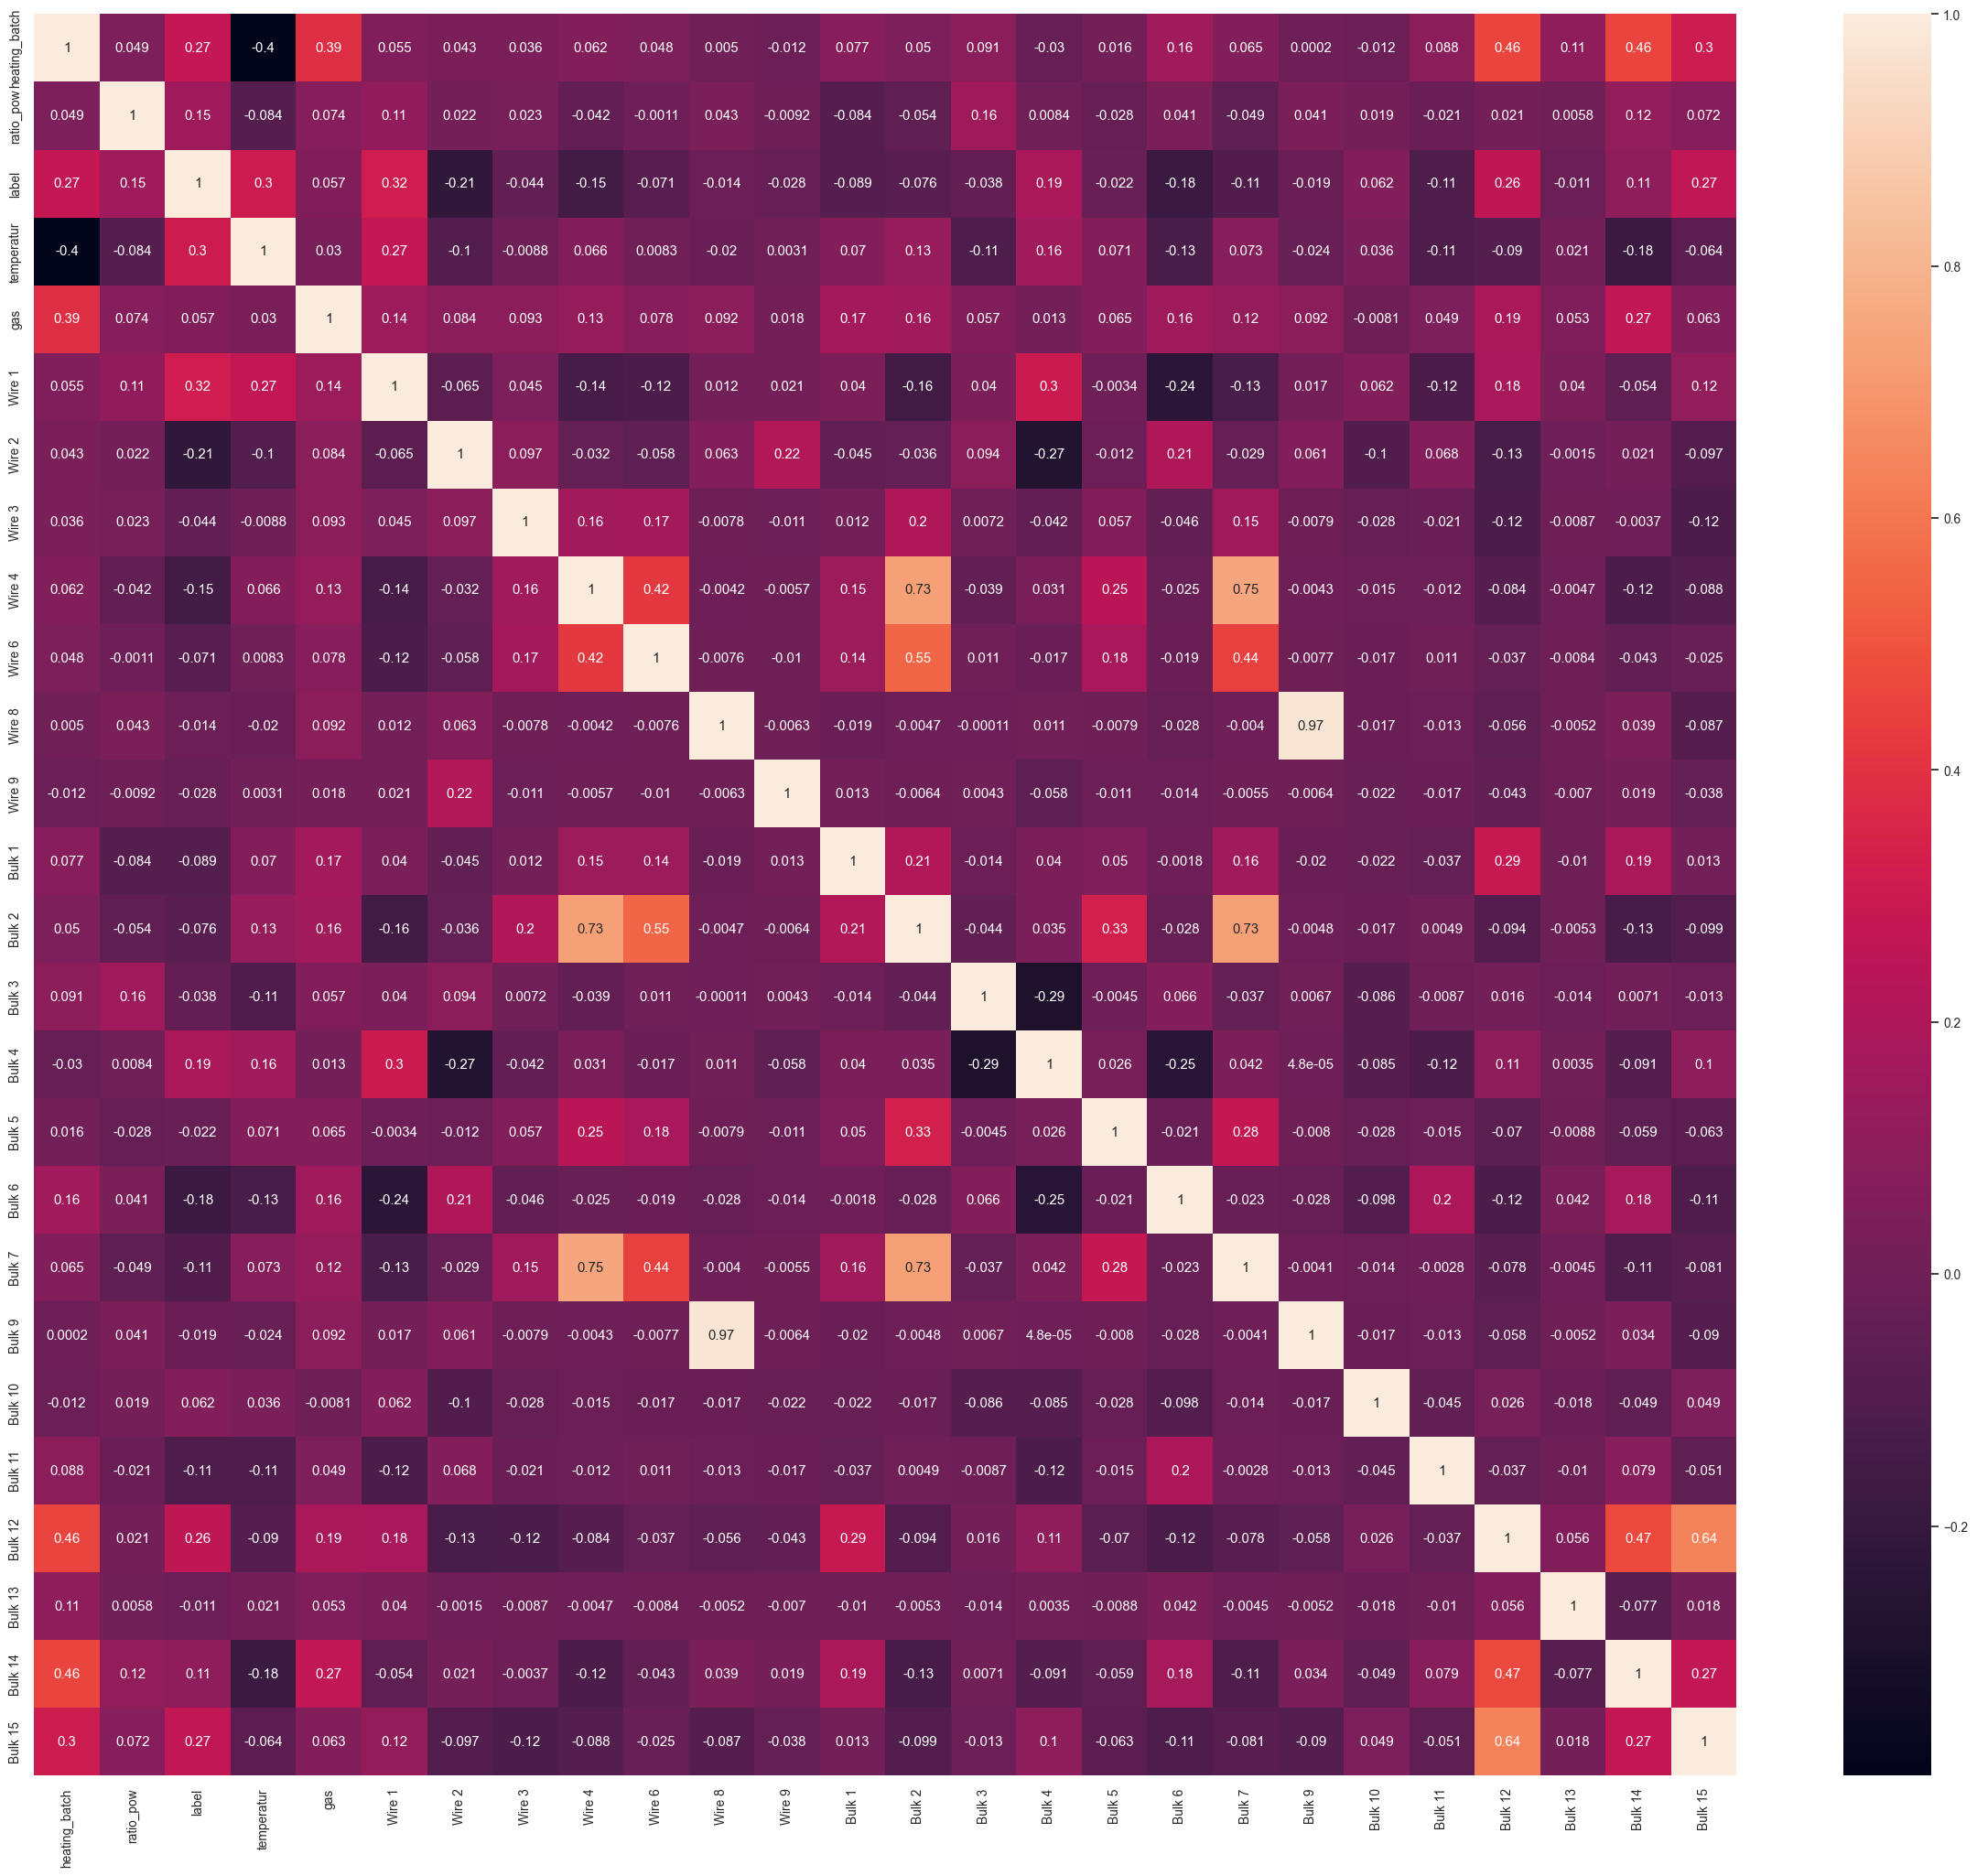

In [33]:
plt.rcParams['figure.figsize'] = 30, 25
sns.set(font_scale=0.9)
sns.heatmap(data.corr(), annot=True)

#### Вывод
Интересно, уже на этом этапе графический анализ указывает на два признака: `Bulk 9`, `Wire 8`.
В последующем анализе важности признаков, эти два признака - какндидаты на удаление, но уже сейчас мы можем удалить
один из них. Это будет `Bulk 9`.

In [34]:
data = data.drop('Bulk 9', axis=1)

In [35]:
train, test = train_test_split(data, test_size=0.2, random_state=12092022)

print(train.shape)
print(test.shape)

X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

(1830, 25)
(458, 25)


### Масштабирование данных

In [36]:
# sc = StandardScaler()
# # вычислим параметры μ (эмпирическое среднее) и σ (стандартное отклонение) для каждой размерности признаков из тренировочных данных
# sc.fit(train)
# # стандартизируем данные, используя для этого расчетные параметры μ и σ.
# X_train_std = sc.transform(train)
# X_test_std = sc.transform(test)

### Обучение и тестирование моделей
Для обучения и сравнения выберим следующие алгоритмы для моделирования:
   - Регуляризованная линейная модель гребневой регрессии `Ridge` (L2 регуляризация)
   - Регуляризованная линейная модель лассо регрессии `Lasso` (L1 регуляризация)
   - Регуляризованная линейная модель регрессии эластичная сетка `ElasticNet` (L1,L2 регуляризации)
   - Ансамбль `Random Forest` (мажоритарное голосование)
   - Ансамбль `Light GBM` (градиентный бустинг)
   - Ансамбль `Cat Boost` (градиентный бустинг)

In [37]:
models = [RidgeCV(alphas=[.1, 1, 10]),
          LassoCV(alphas=[.1, 1, 10]),
          ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10]),
          RandomForestRegressor(),
          LGBMRegressor(),
          CatBoostRegressor()]
pred_train = []
pred_test = []
mae_train = []
mae_test = []


for m in models:
        # обучение
        m.fit(X_train, y_train)
        # прогноз на тренировочной выборке
        prediction_train = m.predict(X_train)
        prediction_test = m.predict(X_test)
        # сохранение результатов прогнозирования
        pred_train.append(prediction_train)
        pred_test.append(prediction_test)
        # оценка прогнозирование
        mae_train.append(round(mean_absolute_error(y_train, prediction_train), 3))
        mae_test.append(round(mean_absolute_error(y_test, prediction_test), 3))

Learning rate set to 0.045045
0:	learn: 11.1351372	total: 189ms	remaining: 3m 8s
1:	learn: 11.0366058	total: 191ms	remaining: 1m 35s
2:	learn: 10.9242875	total: 193ms	remaining: 1m 4s
3:	learn: 10.8138343	total: 196ms	remaining: 48.9s
4:	learn: 10.7076747	total: 199ms	remaining: 39.6s
5:	learn: 10.5935109	total: 201ms	remaining: 33.3s
6:	learn: 10.4895395	total: 203ms	remaining: 28.8s
7:	learn: 10.4102101	total: 205ms	remaining: 25.4s
8:	learn: 10.3060506	total: 207ms	remaining: 22.8s
9:	learn: 10.2173558	total: 210ms	remaining: 20.7s
10:	learn: 10.1640891	total: 212ms	remaining: 19.1s
11:	learn: 10.0828680	total: 214ms	remaining: 17.6s
12:	learn: 10.0109064	total: 216ms	remaining: 16.4s
13:	learn: 9.9235815	total: 219ms	remaining: 15.4s
14:	learn: 9.8478059	total: 221ms	remaining: 14.5s
15:	learn: 9.7822687	total: 223ms	remaining: 13.7s
16:	learn: 9.7233186	total: 226ms	remaining: 13.1s
17:	learn: 9.6600181	total: 228ms	remaining: 12.5s
18:	learn: 9.5992574	total: 231ms	remaining: 11.

### Сравнительная таблица

In [38]:
comparison_table = pd.DataFrame({
    'Model': ['RidgeCV', 'LassoCV', 'ElasticNetCV', 'RandomForestRegressor',
              'LGBMRegressor', 'CatBoostregressor'],
    'MAE train': [mae_train[0], mae_train[1], mae_train[2], mae_train[3],
                   mae_train[4], mae_train[5]],
    'MAE test': [mae_test[0], mae_test[1], mae_test[2], mae_test[3],
                  mae_test[4], mae_test[5]]
})

display(comparison_table)

,Model,MAE train,MAE test
0,RidgeCV,6.146,5.841
1,LassoCV,6.162,5.906
2,ElasticNetCV,6.162,5.906
3,RandomForestRegressor,2.330,5.675
4,LGBMRegressor,3.019,5.710
5,CatBoostregressor,3.054,5.536


#### Вывод
- На этапе моделирования и тестирования удалось достичь качества обучения, удовлетворяющего заданному условию по
оценочной метрике: `MAE < 6.8`;
- Лучшие оценочные показатели на тестовой выборке продемонстировали модели:
    - CatBoostRegressor (градиентный бустинг) - `MAE = 5.5`;
    - RandomForestRegressor (мажоритарное голосование) - `MAE = 5.7`;
    - RidgeCV (регуляризованная линейная модель) - `MAE = 5.8`.
- Ансамбль и бустинговые модели демонстрируют переобучение, скорее всего моделям не хватает тренировочных данных.

### Важность признаков
#### Отбор признаков через атрибут Случайного леса `feature_importances_`

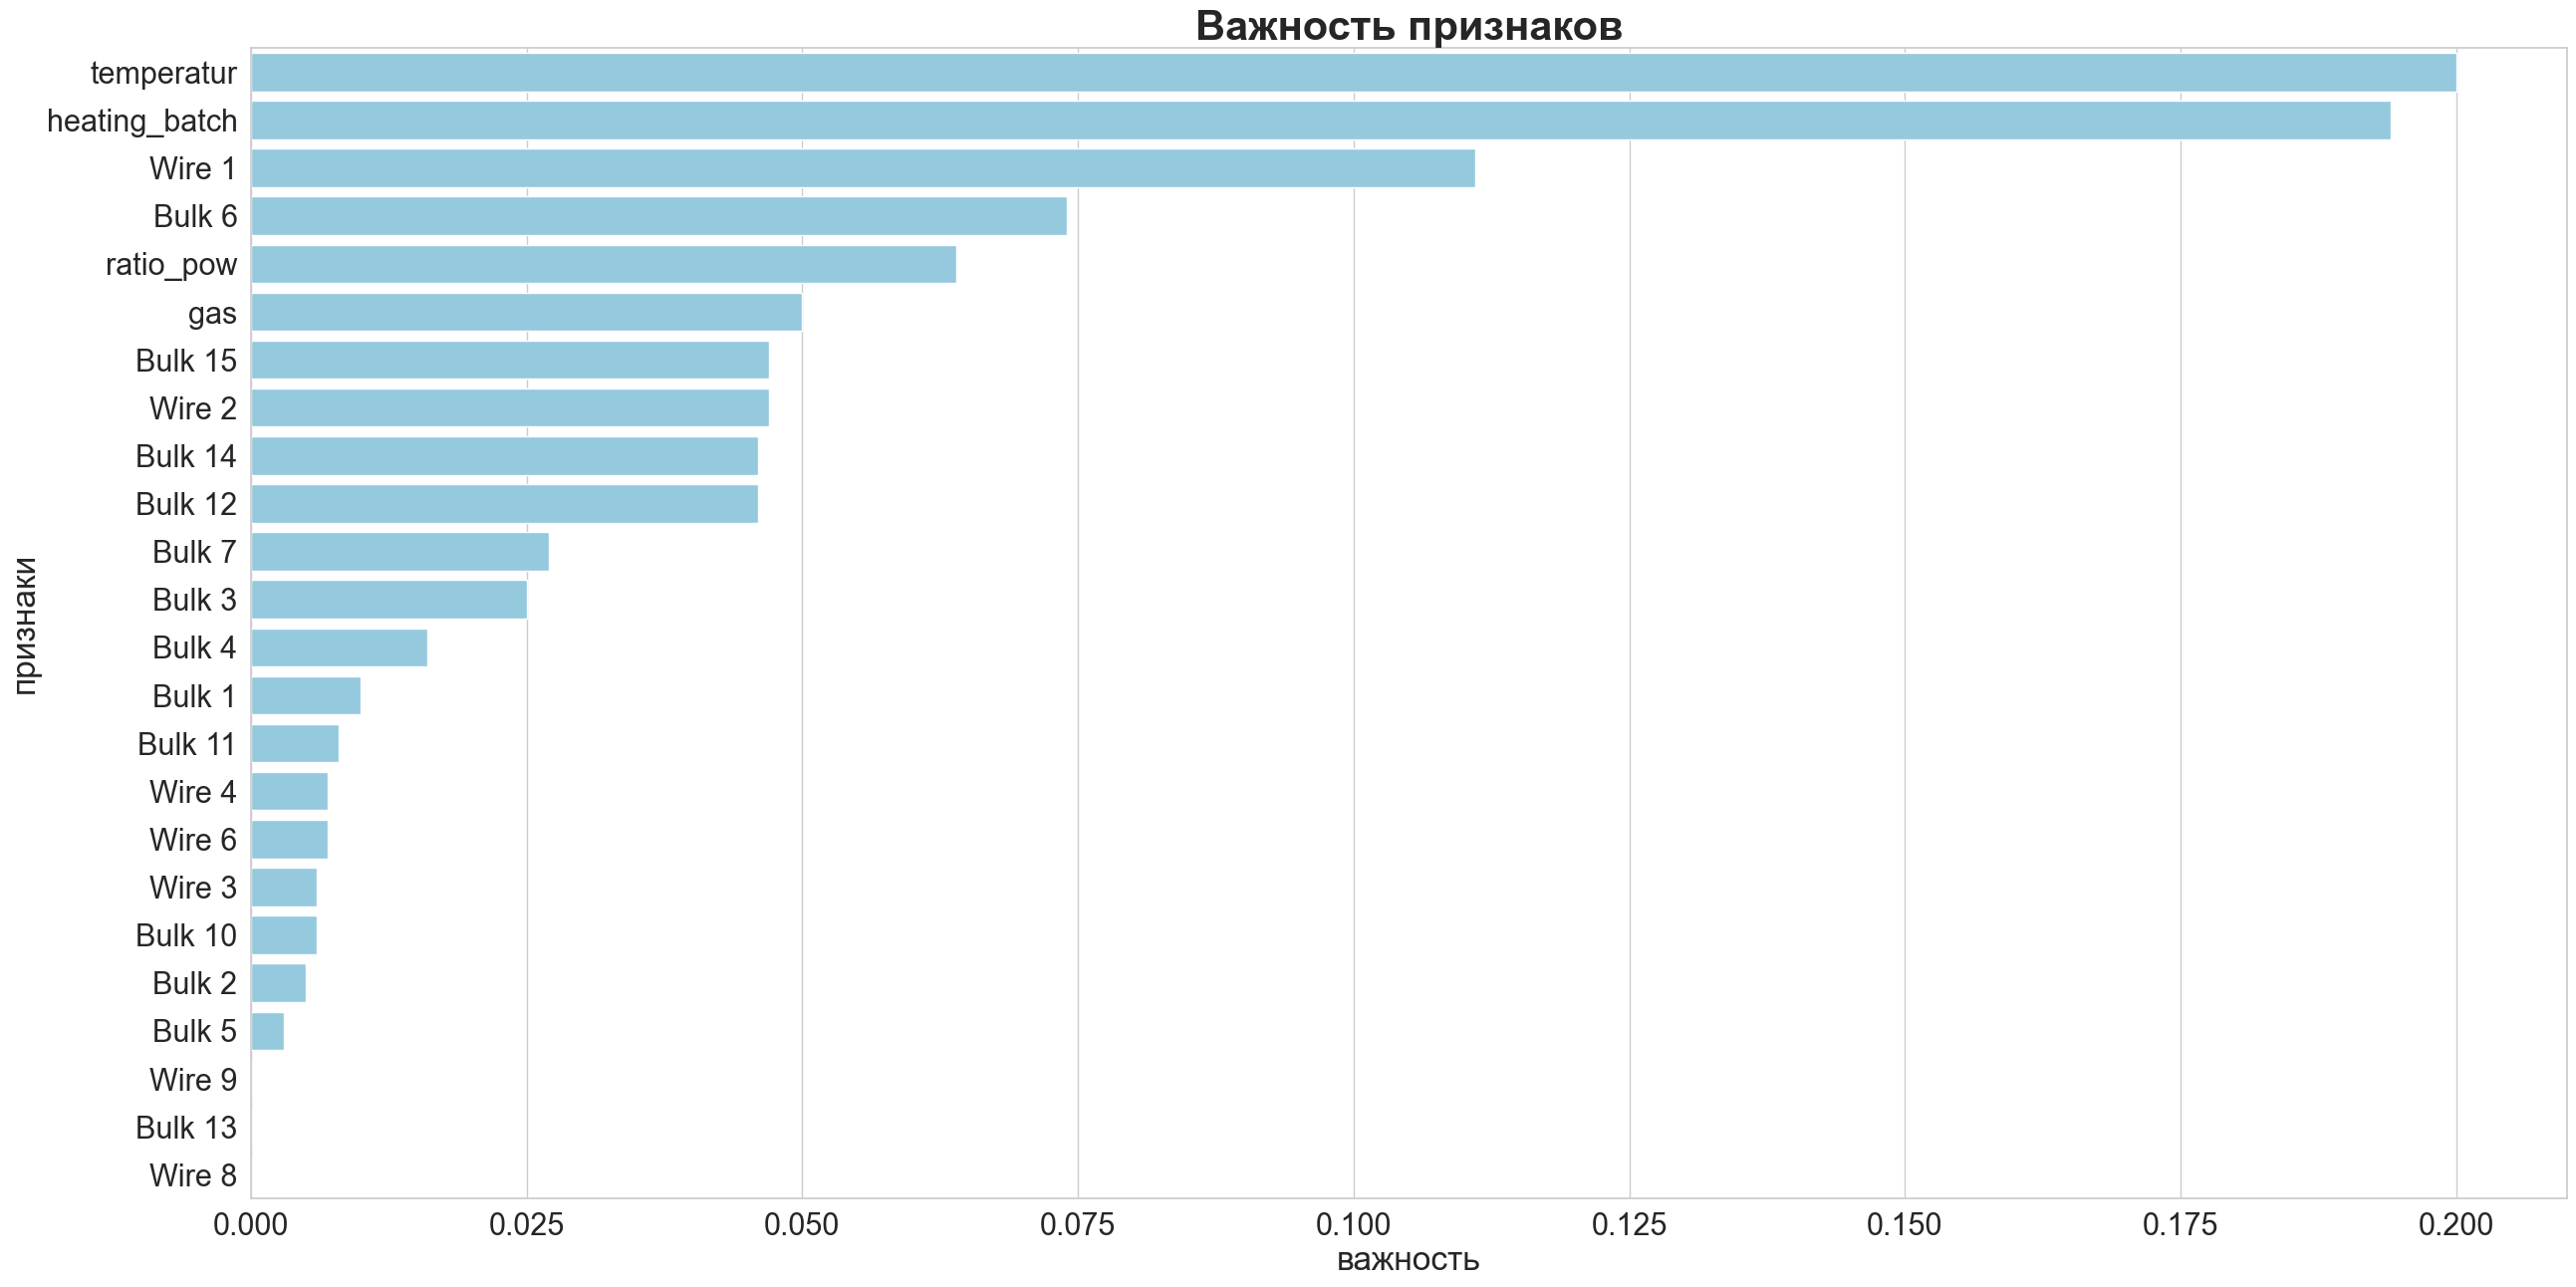

In [39]:
importances = pd.DataFrame({'признаки':X_train.columns,'важность':np.round(models[3].feature_importances_,3)})
importances = importances.sort_values('важность',ascending=False).set_index('признаки')

sns.set(style="whitegrid", color_codes=True, font_scale = 2.0)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['важность'], y=importances.index, data=importances, color='skyblue')
plt.title('Важность признаков', fontsize=30, weight = 'bold')
plt.show()

#### Вывод
Анализ важности признаков говорит о том, что признаки `Bulk 13`, `Wire 8`, `Wire 9` вносят нулевой вклад в общую
карнтину;
Наиболее важные признаки:
- `Продолжительность нагрева партии (heating_batch)`;
- `Начальная температура ковша (temperatur)`.

#### Обучим и протестируем модели с учетом корректировки важности признаков

In [40]:
data = data.drop(['Bulk 13', 'Wire 8', 'Wire 9'], axis=1)

In [41]:
train, test = train_test_split(data, test_size=0.2, random_state=12092022)

print(train.shape)
print(test.shape)

X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

(1830, 22)
(458, 22)


In [42]:
models = [RidgeCV(alphas=[.1, 1, 10]),
          LassoCV(alphas=[.1, 1, 10]),
          ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10]),
          RandomForestRegressor(),
          LGBMRegressor(),
          CatBoostRegressor()]
pred_train = []
pred_test = []
mae_train = []
mae_test = []


for m in models:
    # обучение
    m.fit(X_train, y_train)
    # прогноз на тренировочной выборке
    prediction_train = m.predict(X_train)
    prediction_test = m.predict(X_test)
    # сохранение результатов прогнозирования
    pred_train.append(prediction_train)
    pred_test.append(prediction_test)
    # оценка прогнозирование
    mae_train.append(round(mean_absolute_error(y_train, prediction_train), 3))
    mae_test.append(round(mean_absolute_error(y_test, prediction_test), 3))

Learning rate set to 0.045045
0:	learn: 11.1319075	total: 3.11ms	remaining: 3.1s
1:	learn: 11.0066350	total: 5.89ms	remaining: 2.94s
2:	learn: 10.8901522	total: 8.61ms	remaining: 2.86s
3:	learn: 10.7830664	total: 11.4ms	remaining: 2.83s
4:	learn: 10.6764709	total: 14.1ms	remaining: 2.81s
5:	learn: 10.5670512	total: 16.8ms	remaining: 2.77s
6:	learn: 10.4656160	total: 19.3ms	remaining: 2.74s
7:	learn: 10.3855948	total: 22.1ms	remaining: 2.74s
8:	learn: 10.2956122	total: 24.7ms	remaining: 2.72s
9:	learn: 10.2007842	total: 27.2ms	remaining: 2.7s
10:	learn: 10.1166943	total: 30.3ms	remaining: 2.73s
11:	learn: 10.0340945	total: 32.9ms	remaining: 2.71s
12:	learn: 9.9606100	total: 35.4ms	remaining: 2.69s
13:	learn: 9.8834402	total: 37.8ms	remaining: 2.66s
14:	learn: 9.8180374	total: 40.4ms	remaining: 2.65s
15:	learn: 9.7623161	total: 43ms	remaining: 2.65s
16:	learn: 9.6921255	total: 45.8ms	remaining: 2.65s
17:	learn: 9.6326161	total: 48.6ms	remaining: 2.65s
18:	learn: 9.5844101	total: 51ms	rem

In [43]:
comparison_table = pd.DataFrame({
    'Model': ['RidgeCV', 'LassoCV', 'ElasticNetCV', 'RandomForestRegressor',
              'LGBMRegressor', 'CatBoostregressor'],
    'MAE train': [mae_train[0], mae_train[1], mae_train[2], mae_train[3],
                  mae_train[4], mae_train[5]],
    'MAE test': [mae_test[0], mae_test[1], mae_test[2], mae_test[3],
                 mae_test[4], mae_test[5]]
})
display(comparison_table)

,Model,MAE train,MAE test
0,RidgeCV,6.183,5.848
1,LassoCV,6.196,5.920
2,ElasticNetCV,6.196,5.920
3,RandomForestRegressor,2.345,5.718
4,LGBMRegressor,3.009,5.743
5,CatBoostregressor,3.068,5.599


#### Вывод
После корректировки модели с учетом важности признаков мы упростили модель, метрика на тесте немного просела, но не
критично.

### Тестирование лучшей модели

In [44]:
prediction_test = models[0].predict(X_test)
mae_test = mean_absolute_error(y_test, prediction_test)
print('Лучшая модель - RidgeCV')
print('Средняя абсолютная ошибка', round(mae_test, 1))

Лучшая модель - RidgeCV
Средняя абсолютная ошибка 5.8


# Отчет по проекту
## Описание задачи
### Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить
потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали. В качестве оценочной метрики качества обучения модели использовать `MAE <= 6.8`.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).
## Данные
### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.
### Преобразование данных
На этапе преобразования были использованы следующие подходы:
- преобразование наименований признаков к единому змеиному стилю;
- анализ мультиколлениарности признаков посредством визуализации `heatmap()`. В результате мы отказались от трех
признаков: `Bulk 9`, `activ_pow_batch`, `reactiv_pow_batch`' с коэффициентом корреляции более 0.9;
- анализ пропущенных значений:
      - заполнение пропущенных значений нулями;
      - уход от пропущенных значений через внутреннее соединение таблиц;
- анализ целесообразности использования признаков посредством визуализации `barplot()`. В результате мы отказались от
 трех признаков: `Bulk 8`, `Wire 5`, `Wire 7`, имеющих нулевые значения. Также исключили признаки с датами и временем и таблицы `data_bulk_time`, `data_wire_time`;
- анализ выбросов посредством визуализации `boxplot()`;
- анализ важности признаков посредством визуализации атрибута `feature_importances_` модели `RandomForestRegressor`. В результате мы отказались от трех признаков: `Bulk 13`, `Wire 8`, `Wire 9`;
- создание новых признаков: `Продолжительность нагрева партии (heating_batch)`, `Среднее соотношение активной и
реактивной мощностей (ratio_pow)`, `Начальная температура ковша (temperatur)`;
- в результате предобработки мы получили набор данных: 22 признака, 2287 строк.
## Модель и алгоритмы
Данные после предобработки были разделены на тренировочную и тестовую выборки в пропорции 4:1.
От проверочной выборки мы отказались сознательно, поскольку данных не много. Решено использовать модели с встроенной кросс-валидацией.
Для обучения и сравнения были выбраны следующие алгоритмы для моделирования:
   - Регуляризованная линейная модель гребневой регрессии `RidgeCV` (L2 регуляризация)
   - Регуляризованная линейная модель лассо регрессии `LassoCV` (L1 регуляризация)
   - Регуляризованная линейная модель регрессии эластичная сетка `ElasticNetCV` (L1,L2 регуляризации)
   - Ансамбль `Random Forest` (мажоритарное голосование)
   - Ансамбль `Light GBM` (градиентный бустинг)
   - Ансамбль `Cat Boost` (градиентный бустинг)
## Результат
### Выполнение плана проекта
В ходе моделирования нам не пришлось прибегать к настройке гиперпараметров лучшей модели, поскольку на этапе
первоначального обучения были достигнуты условия оценочной метрики: `MAE = 5.8`.
### Трудности проекта
Возникла небольшая трудность с получением из набора данных конечной температуры ковша в качестве метки. Пришлось
обратиться к ресурсу `StackOverFlow` для поиска решения.
### Ключевые шаги в проекте
1. Разбор задачи.
2. Загрузка и изучение данных.
3. Преобразование данных.
4. Обучение модели.
5. Тестирование модели.
### Итоговая модель
**По результатам исследования заказчику предложена нормализованная модель гребневой регрессии `RidgeCV`.**
**Средняя абсолютная ошибка MAE = 5.8**